In [1]:
import os
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import glob
from astropy.time import Time
from astropy.io import fits
import astropy.wcs as wcs
import certifi
import requests
import urllib.parse
token="549e219d-b0eb-4a19-98ee-3a658af2303b"
import astropy.visualization as visualization
import matplotlib as mpl
mpl.rc('font', family='serif')
from astropy.coordinates import SkyCoord
from astropy import units as u
def wcs_to_pixels(filename,coord):
    # Load the FITS hdulist using astropy.io.fits
    hdulist = fits.open(filename)    
    w = wcs.WCS(hdulist[0].header)
    world= np.array(coord, np.float_)
    pixcrd = w.wcs_world2pix(world, 1)
    return (pixcrd)


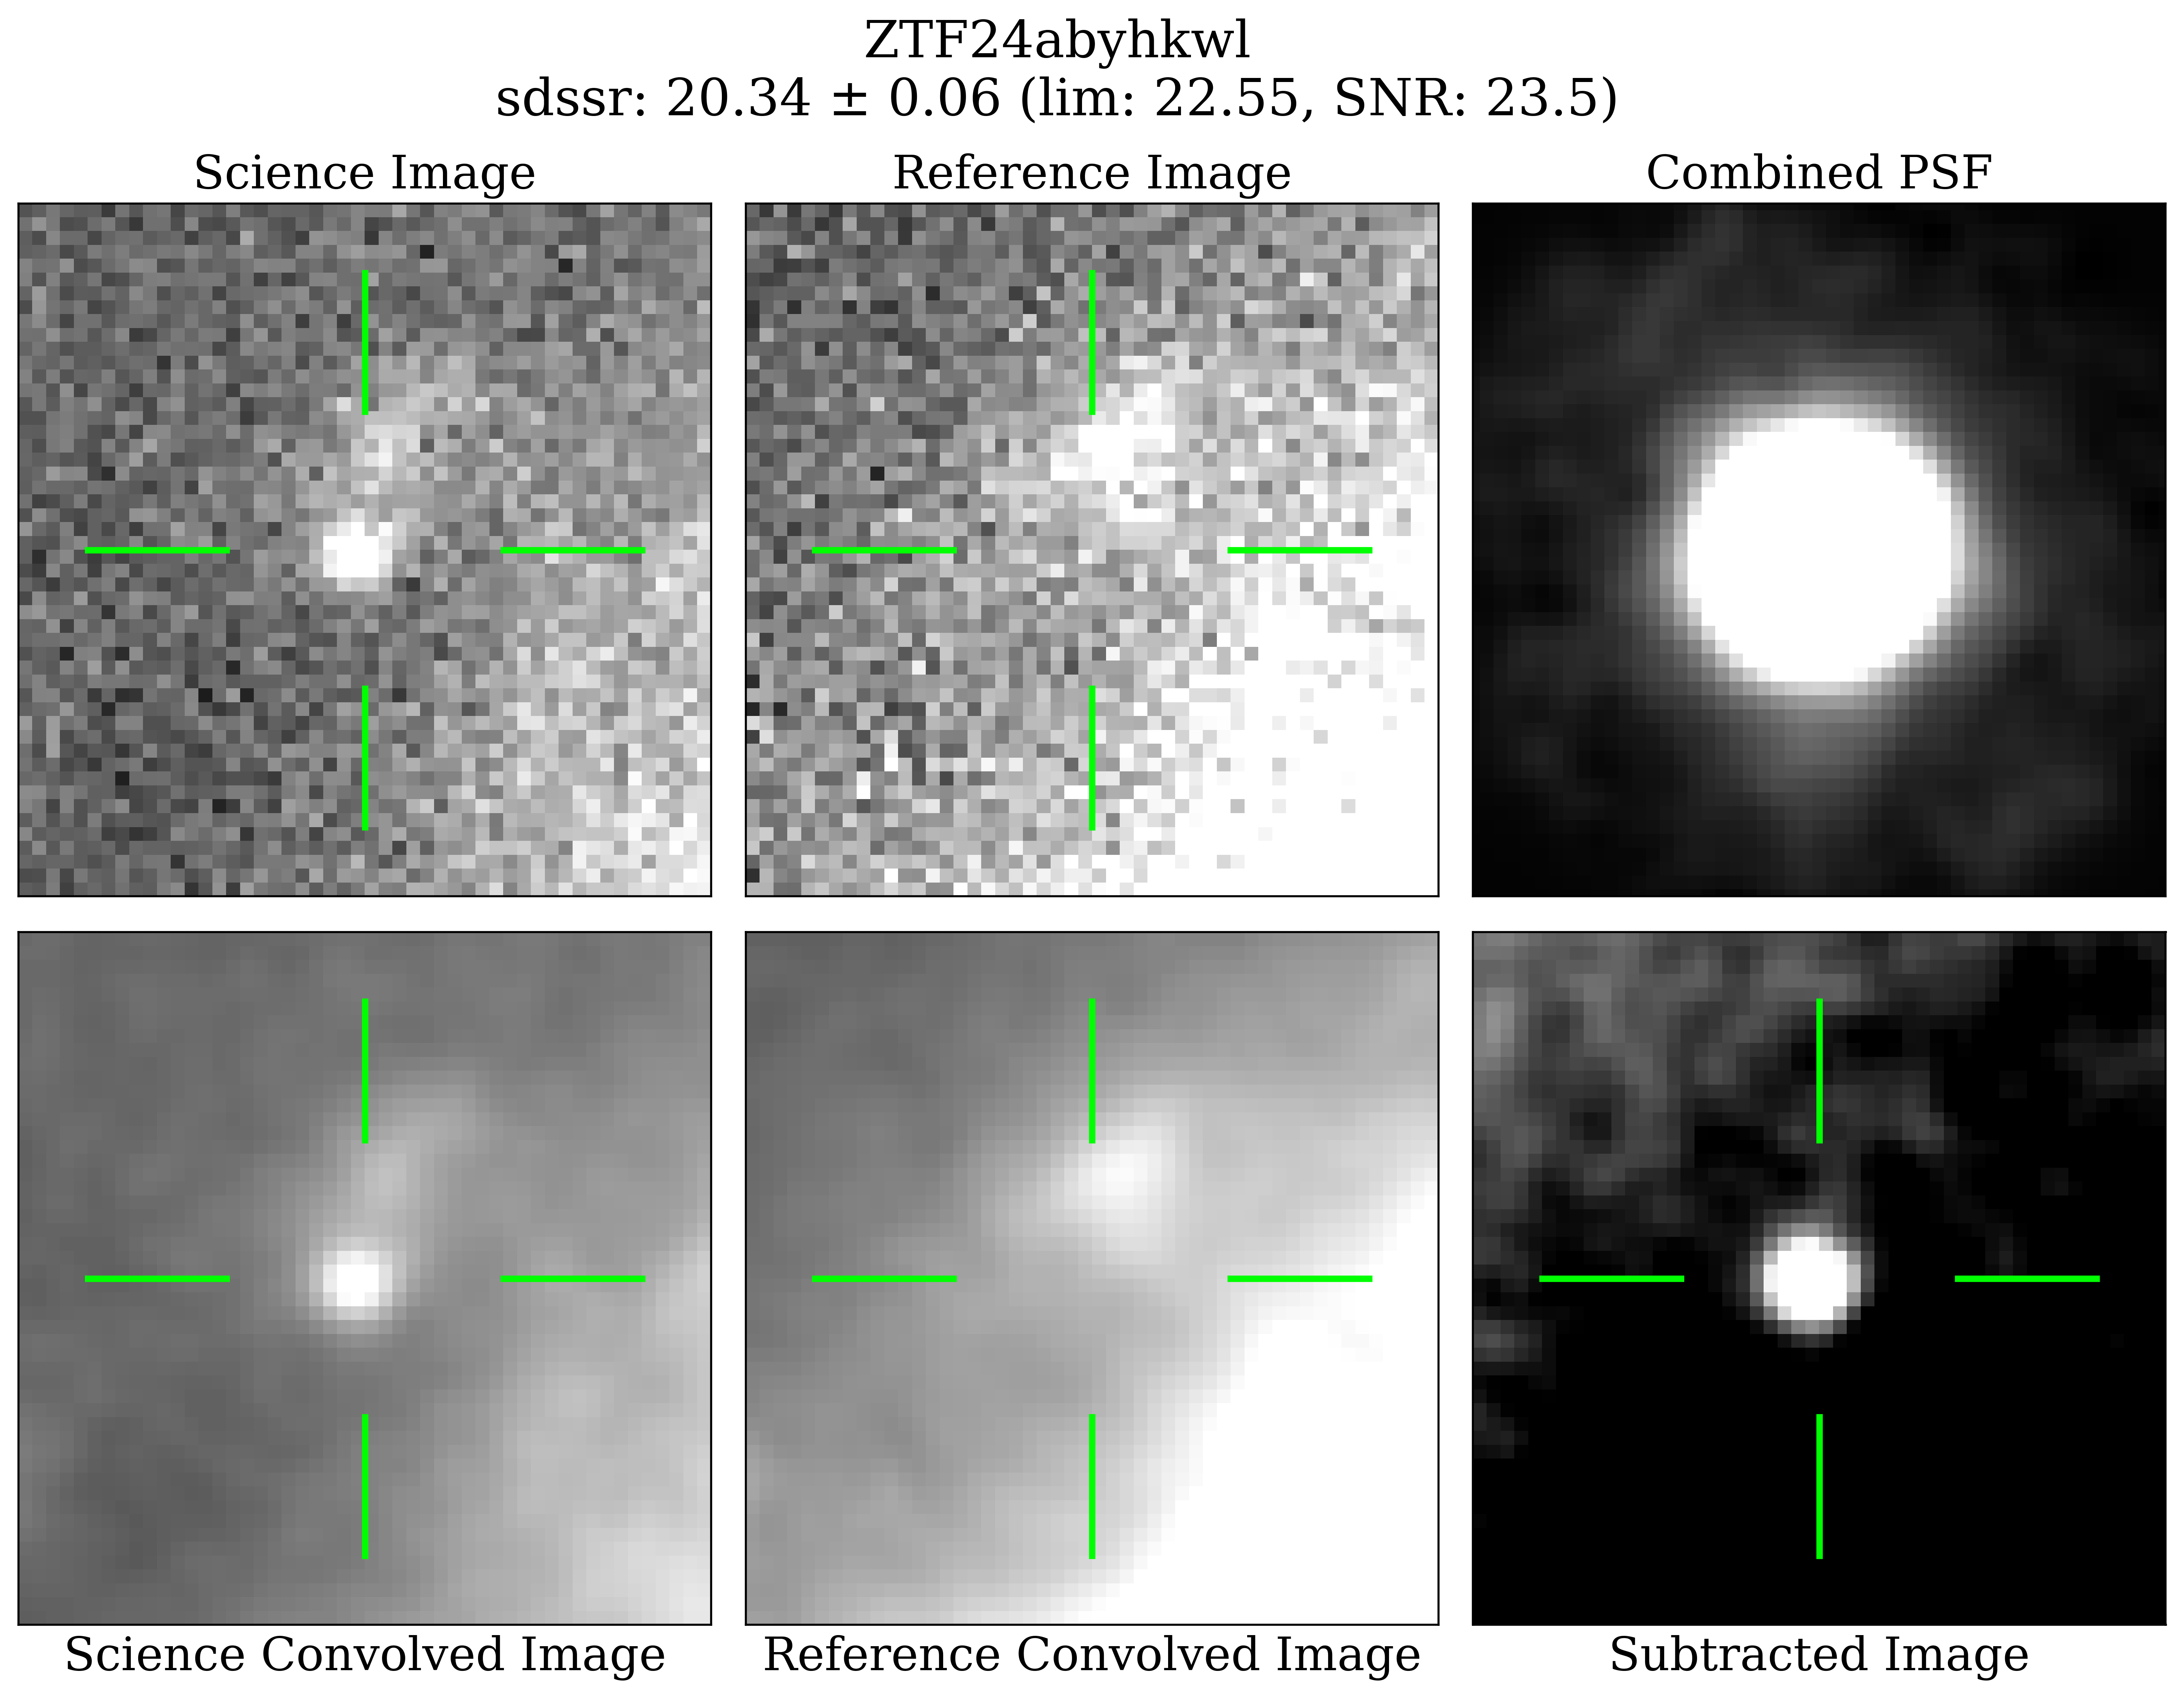

In [46]:
# science, reference, science convolved, reference convolved, subtracted images


sci = '/mnt/data1/users/arikhind/phot_data/aligned_images/ZTF24abyhkwl_r2025-05-08_17089bkgsub_padded.fits'
ref = '/mnt/data1/users/arikhind/phot_data/aligned_images/stack_r_ra251.746000_dec58.433136_arcsec686_skycell2439.065.resamp.fits'

sci_conv = '/mnt/data1/users/arikhind/phot_data/convolved_sci/ZTF24abyhkwl_r_2025-05-08_17089sci_convolved.fits'
ref_conv = '/mnt/data1/users/arikhind/phot_data/convolved_ref/ZTF24abyhkwl_r_2025-05-08_17089ref_convolved.fits'

comb_psf = '/mnt/data1/users/arikhind/phot_data/convolved_psf/ZTF24abyhkwl_r_2025-05-08T04comb_psf_35185.fits'

sub = '/mnt/data1/users/arikhind/phot_data/scaled_subtracted_imgs/ZTF24abyhkwl_r2025-05-08_17089bkgsub_scaled_subtraction.fits'

name = 'ZTF24abyhkwl'

filt = 'r'

snr = '23.5'

mag = '20.34'
radec = '16:46:59.04 +58:25:59.29'
ra,dec = radec.split()

lim = '22.55'

mag_err = '0.06'

def plot_example_images(sci, ref, comb_psf, sci_conv, ref_conv, sub,name,filt,snr,mag,ra,dec,lim,mag_err,minmax='vis'):
  #plot the science, reference, comb_psf, science convolved, reference convolved, subtracted images
  #fig, axs = plt.subplots(1, 5, figsize=(15, 5))
  c = SkyCoord(ra, dec, unit=(u.hourangle, u.deg), frame='icrs')
  ra = c.ra.deg
  dec = c.dec.deg
  coords_pix = wcs_to_pixels(sci, np.column_stack([ra, dec]))
  coords_pix = coords_pix[0]
  coords_pix = coords_pix[0], coords_pix[1]

  fig, axs = plt.subplots(2, 3, figsize=(15, 10), dpi=500,gridspec_kw={'hspace': 0.05, 'wspace': 0.05})
  axs = axs.flatten()
  sci = fits.open(sci)[0].data
  ref = fits.open(ref)[0].data
  comb_psf_d = fits.open(comb_psf)[0].data
  sci_conv_d = fits.open(sci_conv)[0].data
  ref_conv_d = fits.open(ref_conv)[0].data
  sub_d = fits.open(sub)[0].data

  if minmax=='vis':
    sci_minmax = visualization.ZScaleInterval().get_limits(sci)
    ref_minmax = visualization.ZScaleInterval().get_limits(ref)
    comb_psf_minmax = visualization.ZScaleInterval().get_limits(comb_psf_d)
    sci_conv_minmax = visualization.ZScaleInterval().get_limits(sci_conv_d)
    ref_conv_minmax = visualization.ZScaleInterval().get_limits(ref_conv_d)
    sub_minmax = visualization.ZScaleInterval().get_limits(sub_d)
  else:
    sci_minmax = np.percentile(sci, [1, 99])
    ref_minmax = np.percentile(ref, [1, 99])
    comb_psf_minmax = np.percentile(comb_psf_d, [1, 99])
    sci_conv_minmax = np.percentile(sci_conv_d, [1, 99])
    ref_conv_minmax = np.percentile(ref_conv_d, [1, 99])
    sub_minmax = np.percentile(sub_d, [1, 99])

  comb_psf_shape = comb_psf_d.shape
  psf_cent_x, psf_cent_y = comb_psf_shape[0]//2, comb_psf_shape[1]//2
  D=25
  #plot the images
  axs[0].imshow(sci, cmap='gray', vmin=sci_minmax[0], vmax=sci_minmax[1])
  axs[0].set_xlim(coords_pix[0]-D, coords_pix[0]+D),axs[0].set_ylim(coords_pix[1]-D, coords_pix[1]+D)
  axs[0].set_title('Science Image', fontsize=18)
  axs[1].imshow(ref, cmap='gray', vmin=ref_minmax[0], vmax=ref_minmax[1])
  axs[1].set_xlim(coords_pix[0]-D, coords_pix[0]+D),axs[1].set_ylim(coords_pix[1]-D, coords_pix[1]+D)
  axs[1].set_title('Reference Image', fontsize=18)
  axs[2].imshow(comb_psf_d, cmap='gray', vmin=comb_psf_minmax[0], vmax=comb_psf_minmax[1])
  axs[2].set_xlim(psf_cent_x-D, psf_cent_x+D),axs[2].set_ylim(psf_cent_y-D, psf_cent_y+D)
  axs[2].set_title('Combined PSF', fontsize=18)
  axs[3].imshow(sci_conv_d, cmap='gray', vmin=sci_minmax[0], vmax=sci_minmax[1])
  axs[3].set_xlim(coords_pix[0]-D, coords_pix[0]+D),axs[3].set_ylim(coords_pix[1]-D, coords_pix[1]+D)
  axs[3].set_xlabel('Science Convolved Image', fontsize=18)
  axs[4].imshow(ref_conv_d, cmap='gray', vmin=ref_minmax[0], vmax=ref_minmax[1])
  axs[4].set_xlim(coords_pix[0]-D, coords_pix[0]+D),axs[4].set_ylim(coords_pix[1]-D, coords_pix[1]+D)
  axs[4].set_xlabel('Reference Convolved Image', fontsize=18)
  axs[5].imshow(sub_d, cmap='gray', vmin=sub_minmax[0], vmax=sub_minmax[1])
  axs[5].set_xlim(coords_pix[0]-D, coords_pix[0]+D),axs[5].set_ylim(coords_pix[1]-D, coords_pix[1]+D)
  axs[5].set_xlabel('Subtracted Image', fontsize=18)

  #remove ticks
  for ax in axs:
      ax.set_xticks([])
      ax.set_yticks([])
      # add cross hairs
      ax.plot([coords_pix[0],coords_pix[0]],[coords_pix[1]-10,coords_pix[1]-20],color='lime',lw=2.5)
      ax.plot([coords_pix[0]-10,coords_pix[0]-20],[coords_pix[1],coords_pix[1]],color='lime',lw=2.5)
      ax.plot([coords_pix[0],coords_pix[0]],[coords_pix[1]+10,coords_pix[1]+20],color='lime',lw=2.5)
      ax.plot([coords_pix[0]+10,coords_pix[0]+20],[coords_pix[1],coords_pix[1]],color='lime',lw=2.5)

  #save to ThesisFigs
  fig.suptitle(f'{name}\nsdss{filt}: {mag} ± {mag_err} (lim: {lim}, SNR: {snr})', fontsize=20)
  fig.savefig(f'ThesisFigs/{name}_{filt}_snr{snr}_mag{mag}_ra{ra}_dec{dec}_lim{lim}.pdf',
              bbox_inches='tight')

  
plot_example_images(sci, ref, comb_psf, sci_conv, ref_conv, sub,name,filt,snr,mag,ra,dec,lim,mag_err)




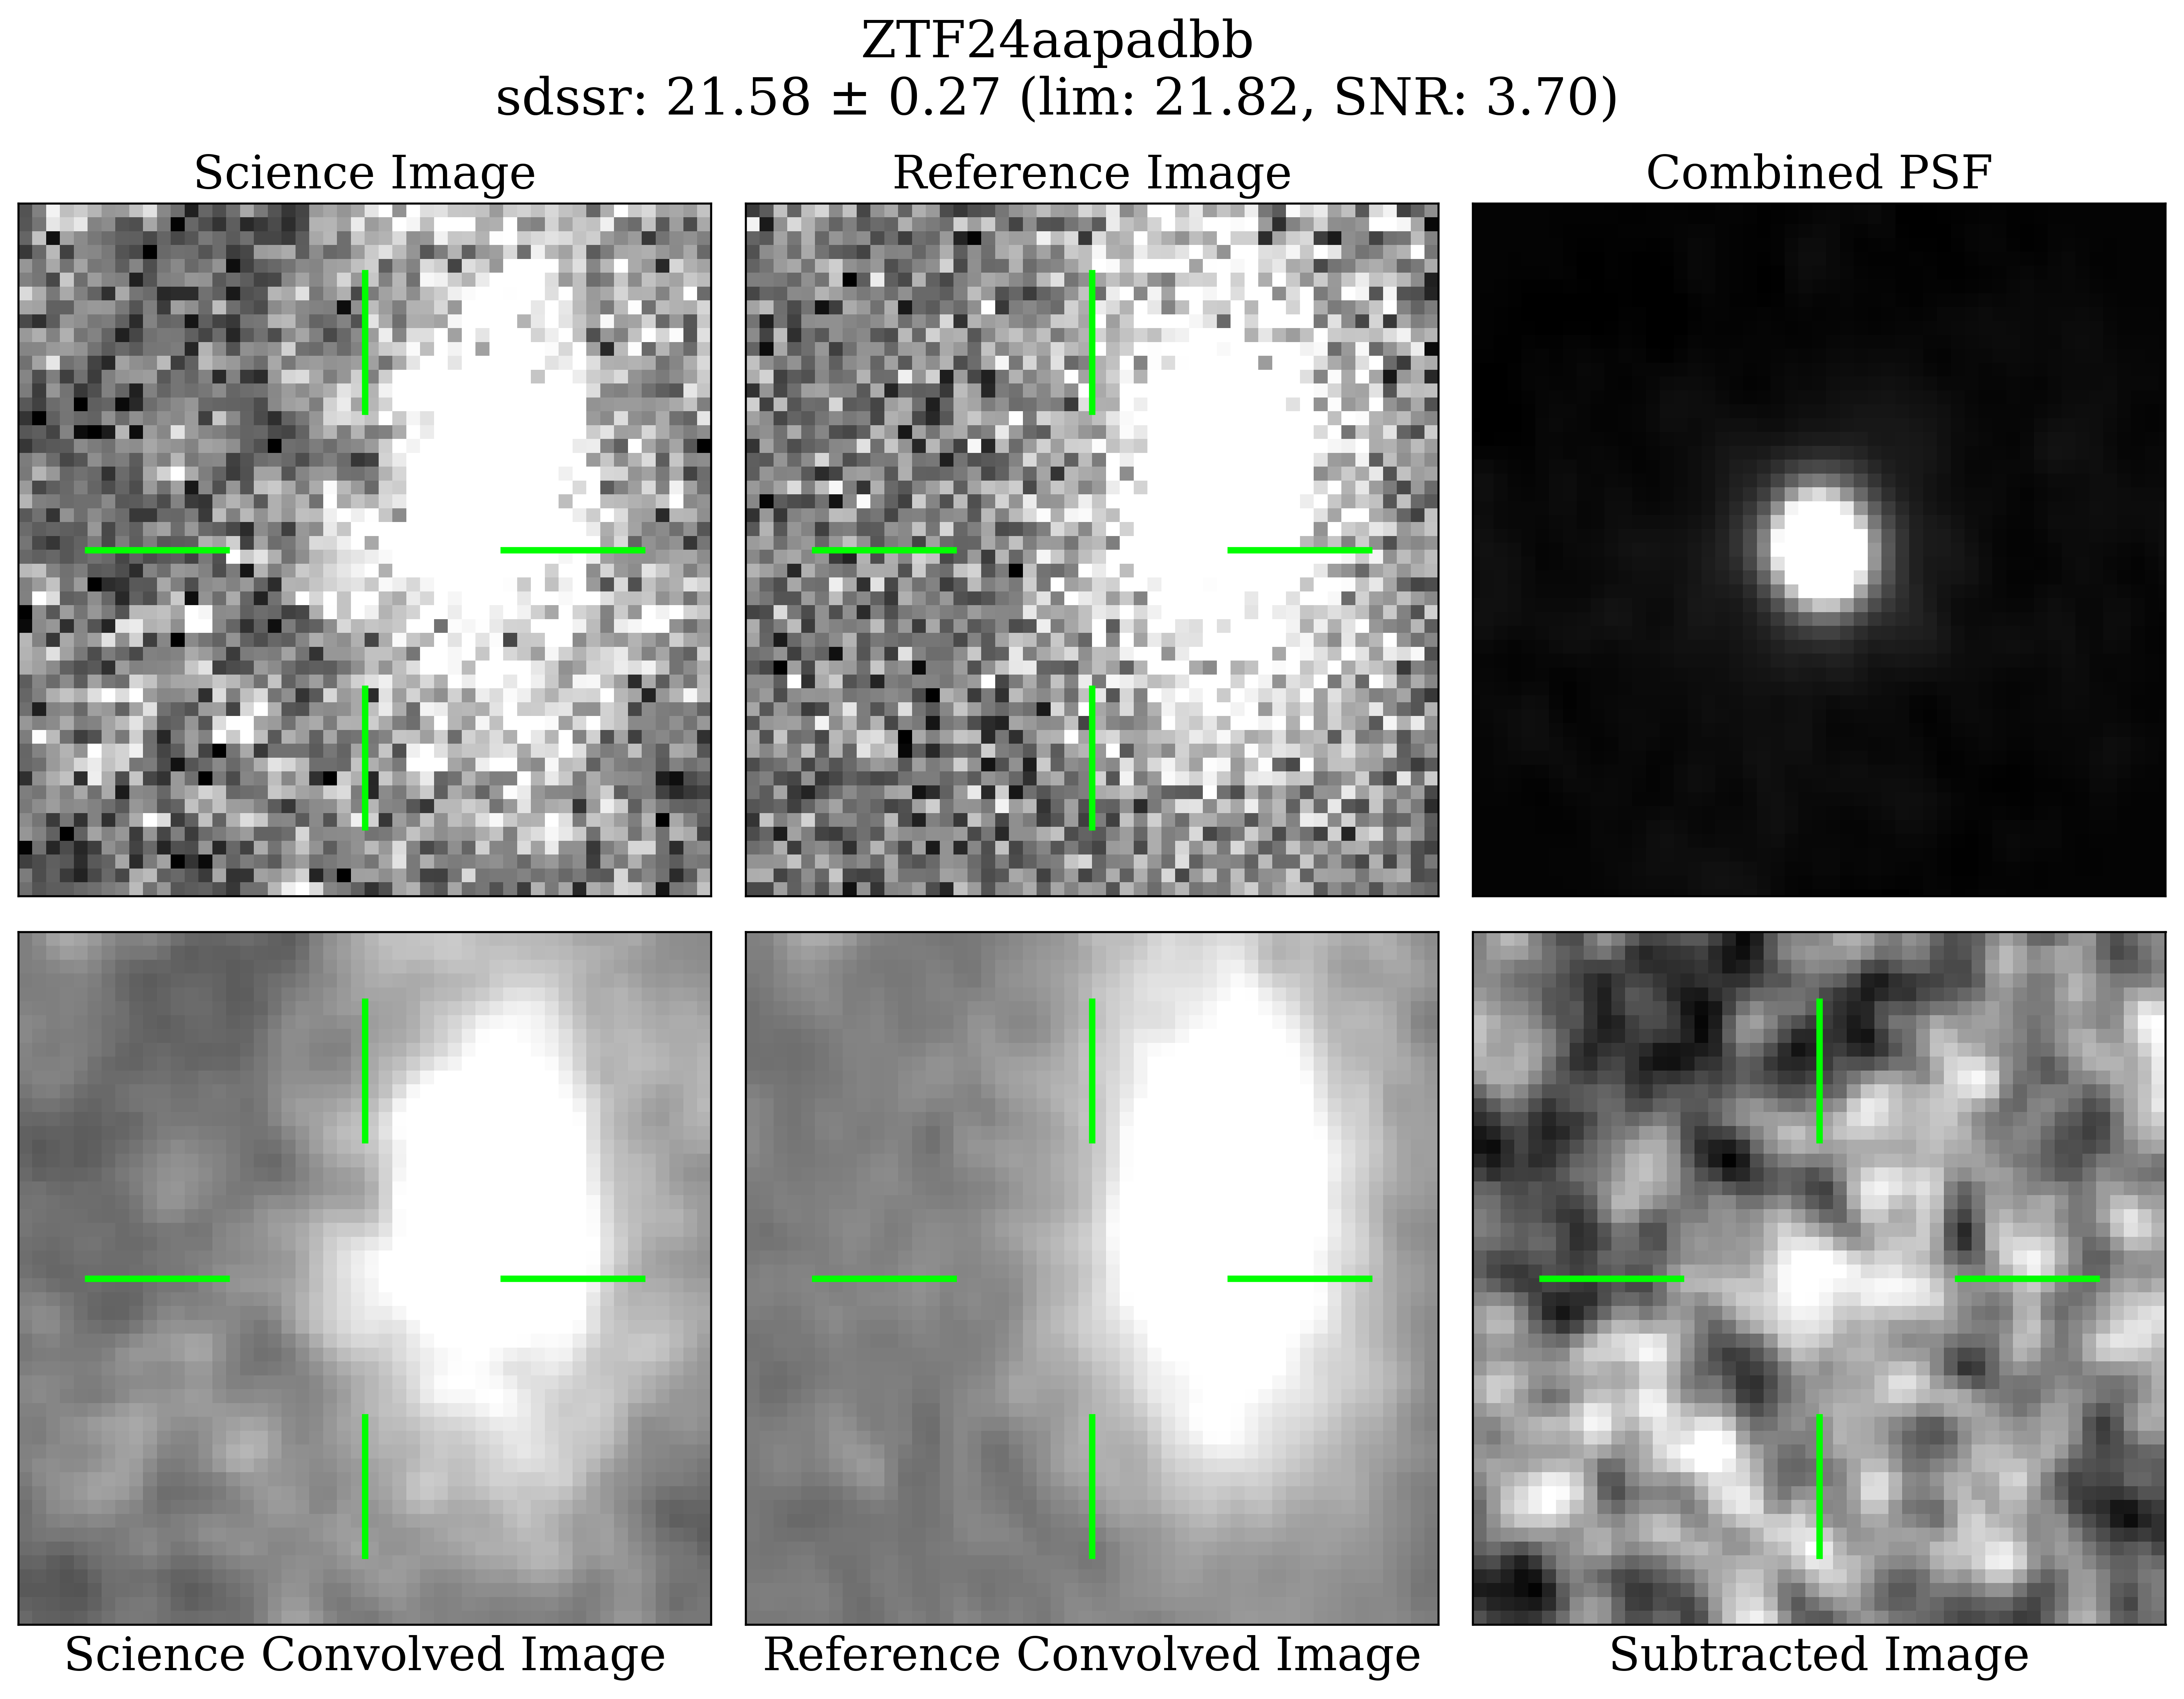

In [53]:
sci = '/mnt/data1/users/arikhind/phot_data/aligned_images/ZTF24aapadbb_i2025-05-07_4932bkgsub.resamp.fits'
ref = '/mnt/data1/users/arikhind/phot_data/aligned_images/stack_i_ra230.495042_dec62.806331_arcsec1500_skycell2483.076.resamp.fits'

sci_conv = '/mnt/data1/users/arikhind/phot_data/convolved_sci/ZTF24aapadbb_i_2025-05-07_4932sci_convolved.fits'
ref_conv = '/mnt/data1/users/arikhind/phot_data/convolved_ref/ZTF24aapadbb_i_2025-05-07_4932ref_convolved.fits'

comb_psf = '/mnt/data1/users/arikhind/phot_data/convolved_psf/ZTF24aapadbb_i_2025-05-07T01comb_psf_67058.fits'

sub = '/mnt/data1/users/arikhind/phot_data/scaled_subtracted_imgs/ZTF24aapadbb_i2025-05-07_4932bkgsub_scaled_subtraction.fits'

name = 'ZTF24aapadbb'

filt = 'r'

snr = '3.70'

mag = '21.58'
radec = '15h21m58.81s +62d48m22.79s'
ra,dec = radec.split()

lim = '21.82'

mag_err = '0.27'

plot_example_images(sci, ref, comb_psf, sci_conv, ref_conv, sub,name,filt,snr,mag,ra,dec,lim,mag_err,minmax='n')

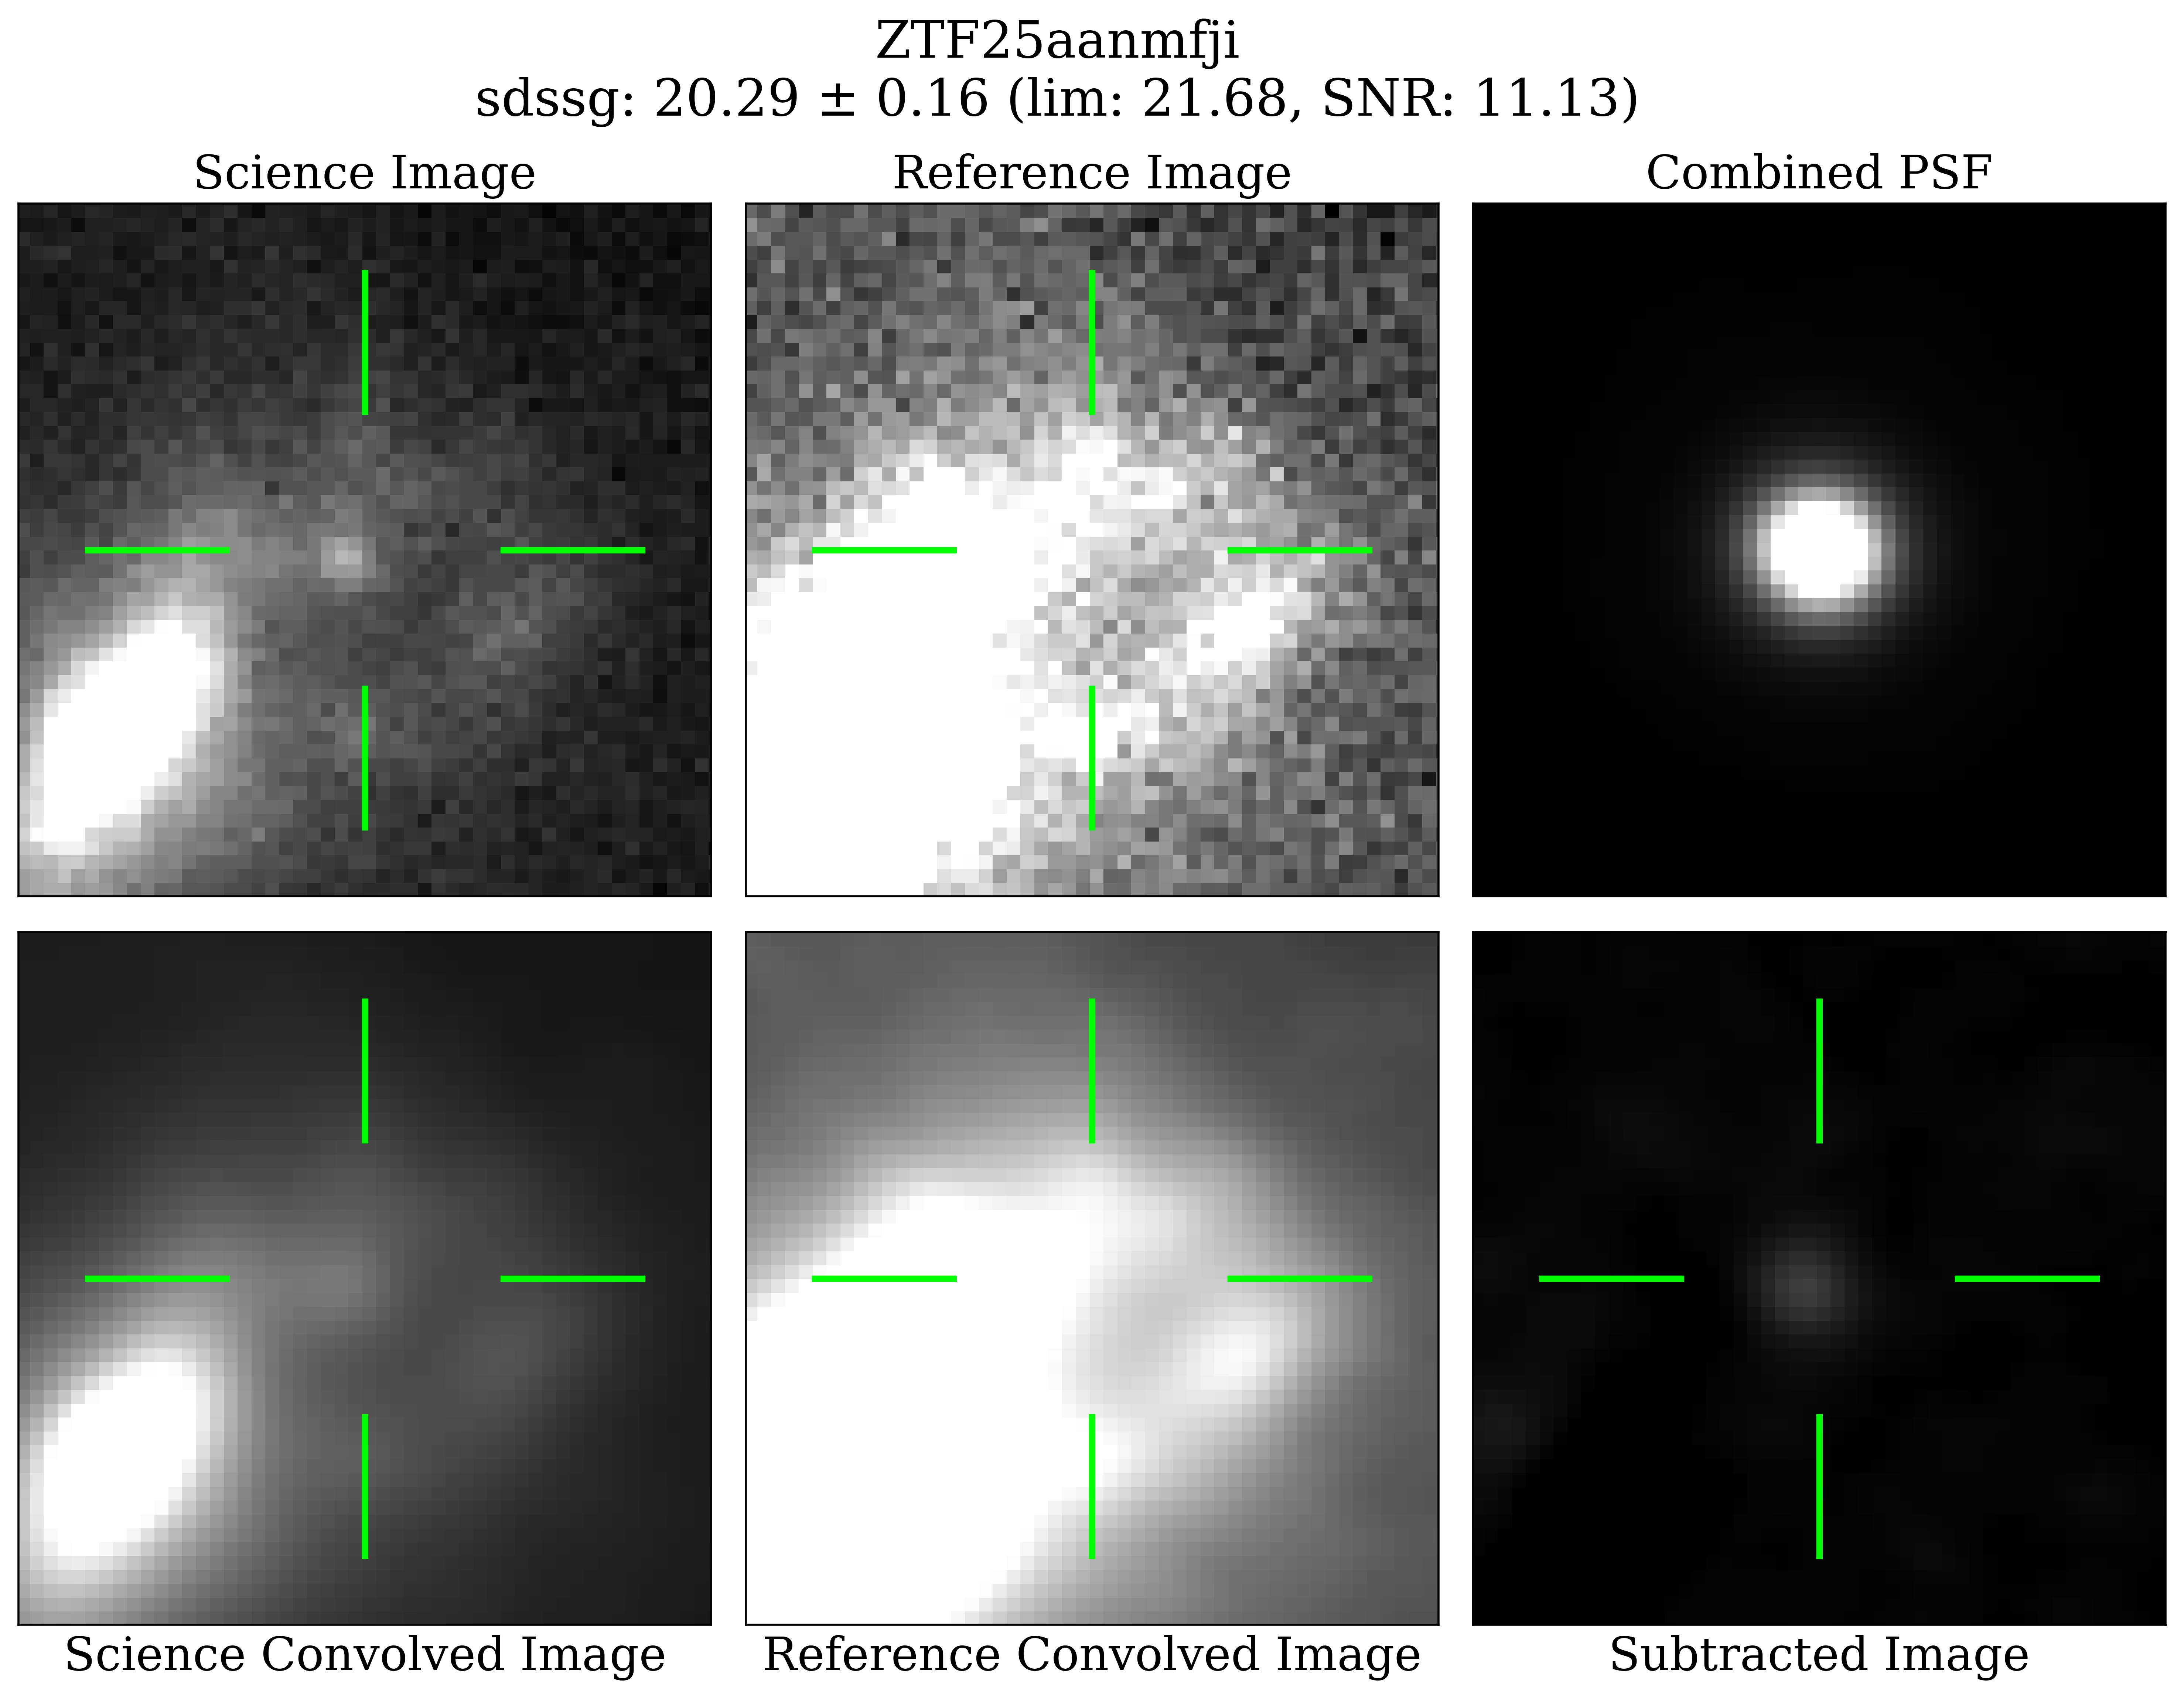

In [ ]:
sci = '/mnt/data1/users/arikhind/phot_data/aligned_images/ZTF25aanmfji_g2025-04-24_16238bkgsub.resamp.fits'
ref = '/mnt/data1/users/arikhind/phot_data/aligned_images/stack_g_ra313.715458_dec65.160417_arcsec686_skycell2533.025.resamp.fits'

sci_conv = '/mnt/data1/users/arikhind/phot_data/convolved_sci/ZTF25aanmfji_g_2025-04-24_16238sci_convolved.fits'
ref_conv = '/mnt/data1/users/arikhind/phot_data/convolved_ref/ZTF25aanmfji_g_2025-04-24_16238ref_convolved.fits'

comb_psf = '/mnt/data1/users/arikhind/phot_data/convolved_psf/ZTF25aanmfji_g_2025-04-24T04comb_psf_50944.fits'

sub = '/mnt/data1/users/arikhind/phot_data/scaled_subtracted_imgs/ZTF25aanmfji_g2025-04-24_16238bkgsub_scaled_subtraction.fits'

name = 'ZTF25aanmfji'

filt = 'g'

snr = '11.13'

mag = '20.29'
radec = '20:54:51.70 +65:09:37.52'
ra,dec = radec.split()

lim = '21.68'

mag_err = '0.16'



plot_example_images(sci, ref, comb_psf, sci_conv, ref_conv, sub,name,filt,snr,mag,ra,dec,lim,mag_err,minmax='n')

In [ ]:
sci = '/mnt/data1/users/arikhind/phot_data/aligned_images/ZTF25aalbnkr_u2025-04-20_76250bkgsub.resamp.fits'
ref = '/mnt/data1/users/arikhind/phot_data/aligned_images/ZTF25aalbnkr_ref_u.resamp.fits'

sci_conv = '/mnt/data1/users/arikhind/phot_data/convolved_sci/ZTF25aalbnkr_u_2025-04-20_76250sci_convolved.fits'
ref_conv = '/mnt/data1/users/arikhind/phot_data/convolved_ref/ZTF25aalbnkr_u_2025-04-20_76250ref_convolved.fits'

comb_psf = '/mnt/data1/users/arikhind/phot_data/convolved_psf/ZTF25aanmfji_g_2025-04-24T04comb_psf_50944.fits'

sub = '/mnt/data1/users/arikhind/phot_data/scaled_subtracted_imgs/ZTF25aanmfji_g2025-04-24_16238bkgsub_scaled_subtraction.fits'

name = 'ZTF25aalbnkr'

filt = ''

snr = '11.13'

mag = '20.29'
radec = '08:41:47.10 +57:13:16.75'
ra,dec = radec.split()

lim = '21.68'

mag_err = '0.16'



plot_example_images(sci, ref, comb_psf, sci_conv, ref_conv, sub,name,filt,snr,mag,ra,dec,lim,mag_err,minmax='n')

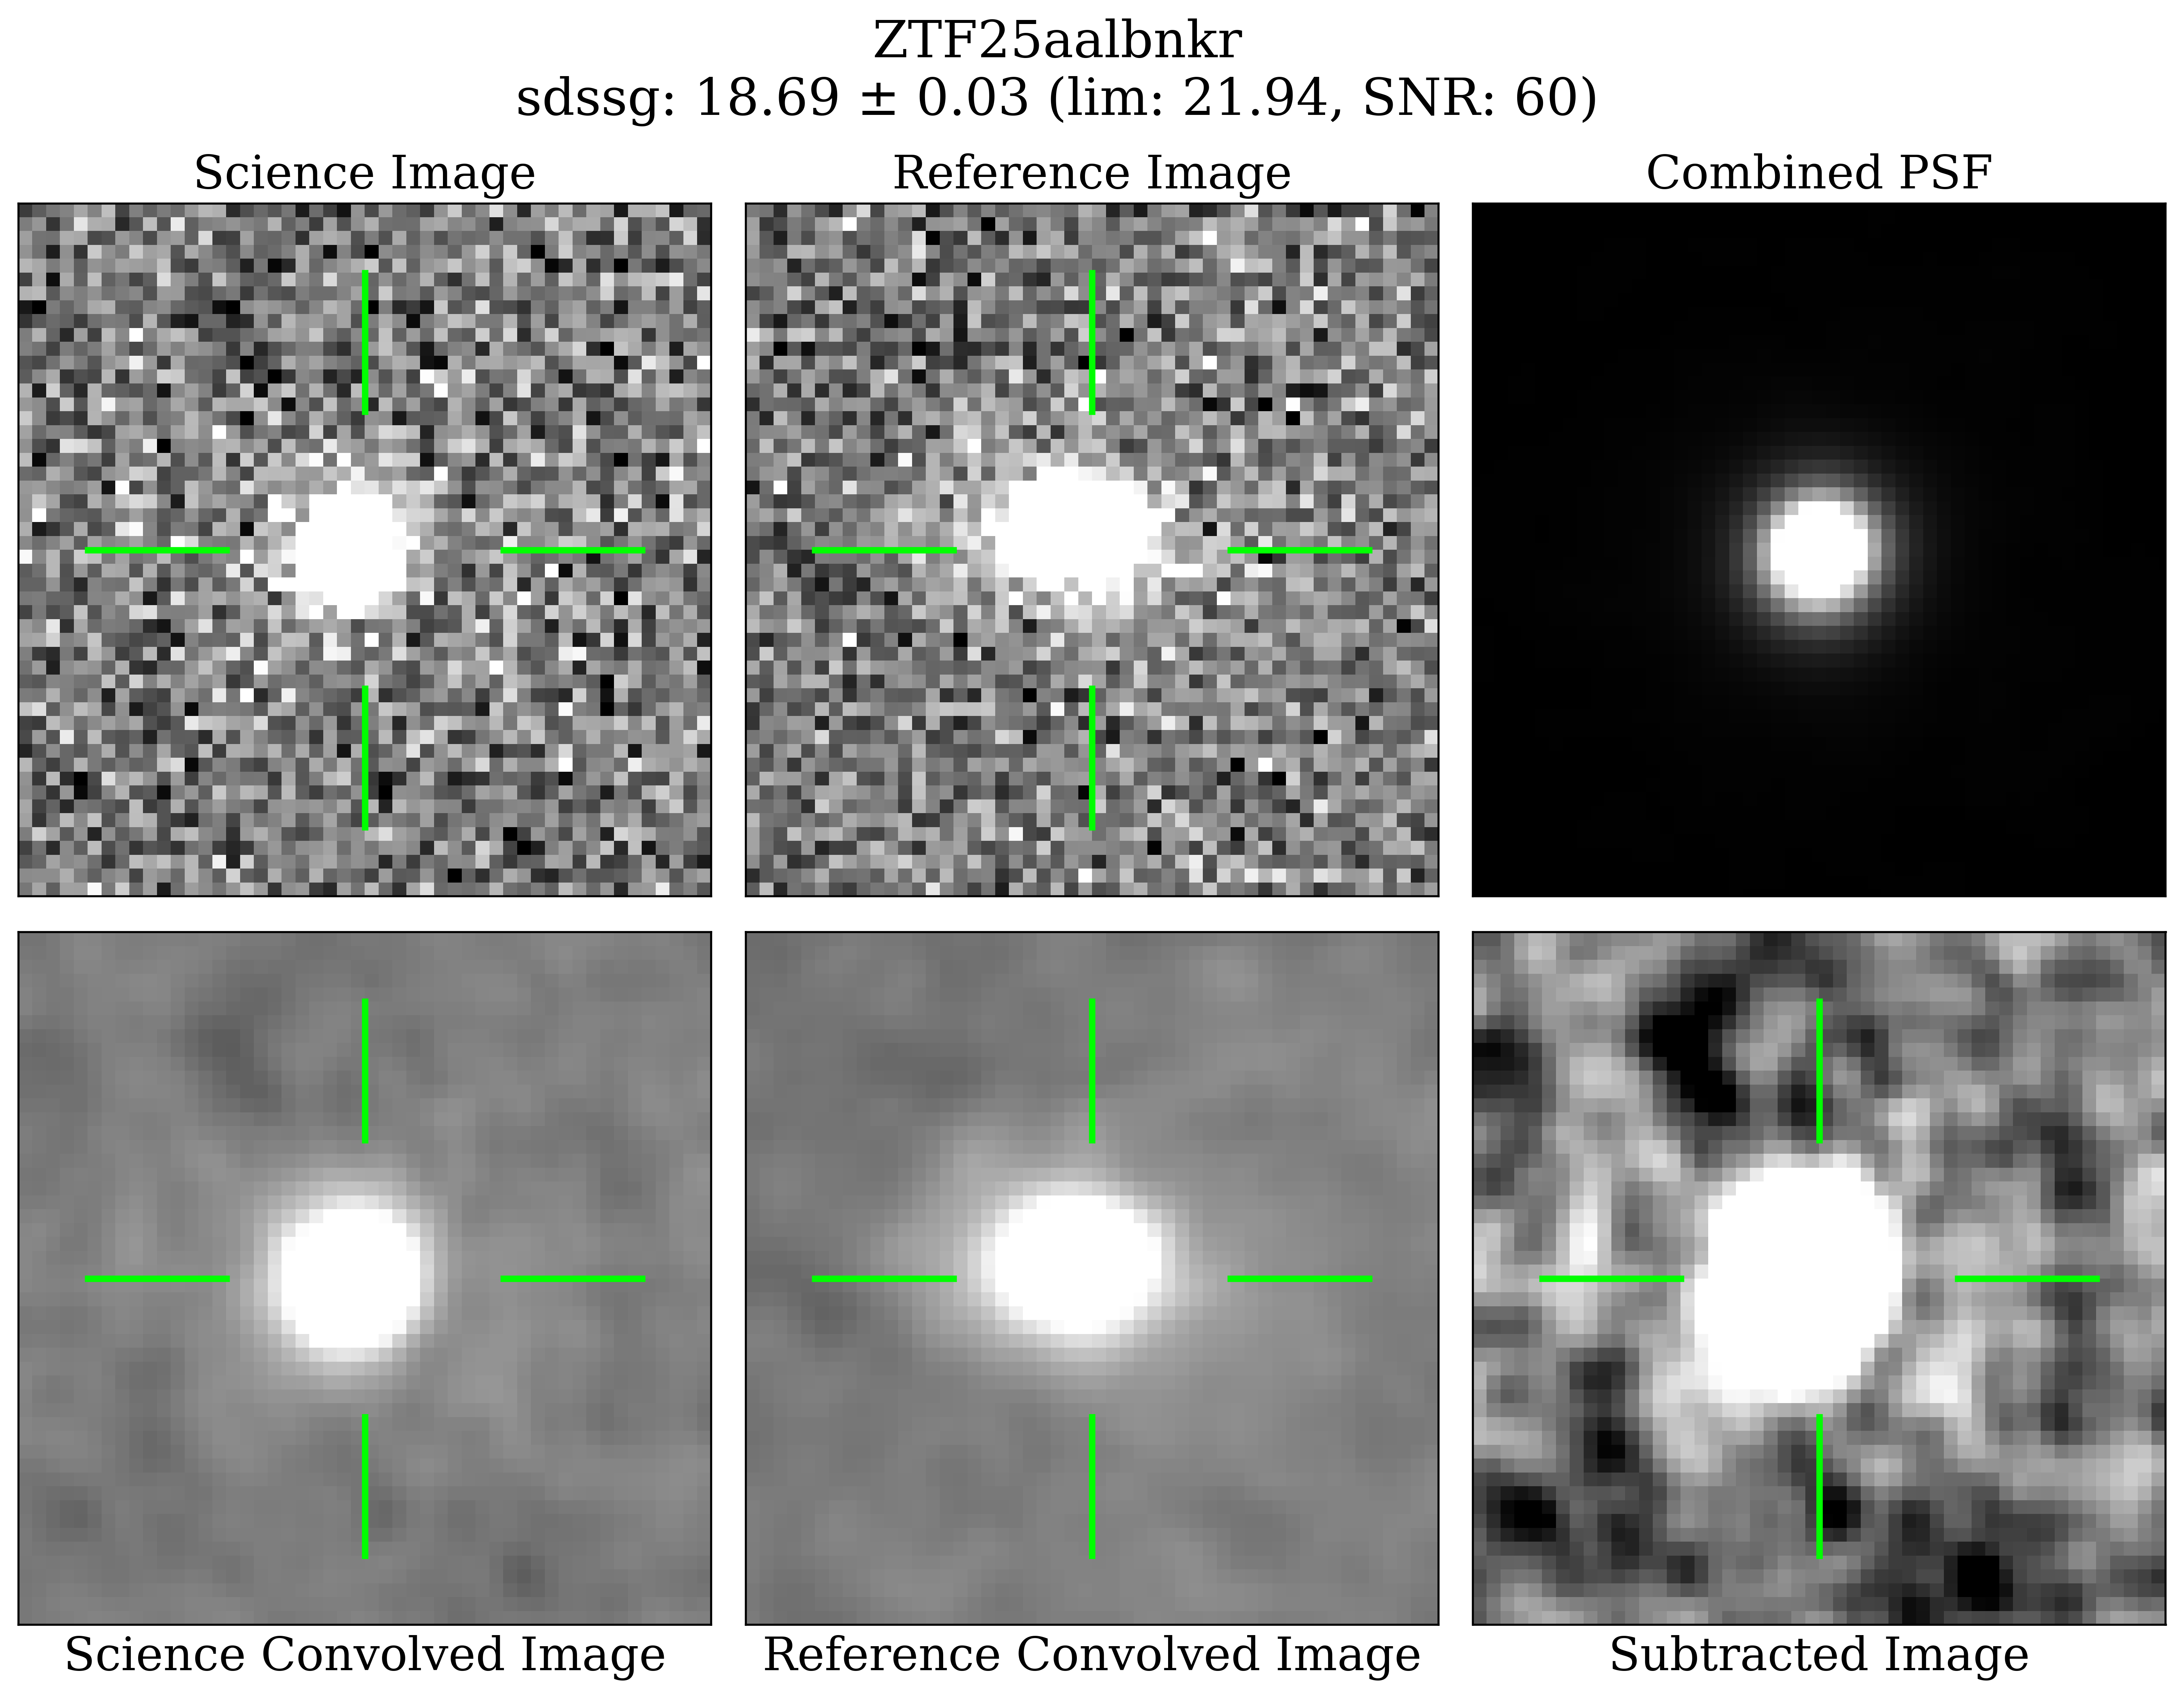

In [51]:
sci = '/mnt/data1/users/arikhind/phot_data/aligned_images/ZTF25aalbnkr_g2025-04-20_75886bkgsub.resamp.fits'
ref = '/mnt/data1/users/arikhind/phot_data/aligned_images/stack_g_ra130.446250_dec57.221319_arcsec686_skycell2422.033.resamp.fits'

sci_conv = '/mnt/data1/users/arikhind/phot_data/convolved_sci/ZTF25aalbnkr_g_2025-04-20_75886sci_convolved.fits'
ref_conv = '/mnt/data1/users/arikhind/phot_data/convolved_ref/ZTF25aalbnkr_g_2025-04-20_75886ref_convolved.fits'

comb_psf = '/mnt/data1/users/arikhind/phot_data/convolved_psf/ZTF25aalbnkr_g_2025-04-20T21comb_psf_70416.fits'

sub = '/mnt/data1/users/arikhind/phot_data/scaled_subtracted_imgs/ZTF25aalbnkr_g2025-04-20_75886bkgsub_scaled_subtraction.fits'

name = 'ZTF25aalbnkr'

filt = 'g'

snr = '60'

mag = '18.69'
radec = '08:41:47.10 +57:13:16.75'
ra,dec = radec.split()

lim = '21.94'

mag_err = '0.03'



plot_example_images(sci, ref, comb_psf, sci_conv, ref_conv, sub,name,filt,snr,mag,ra,dec,lim,mag_err,minmax='n')

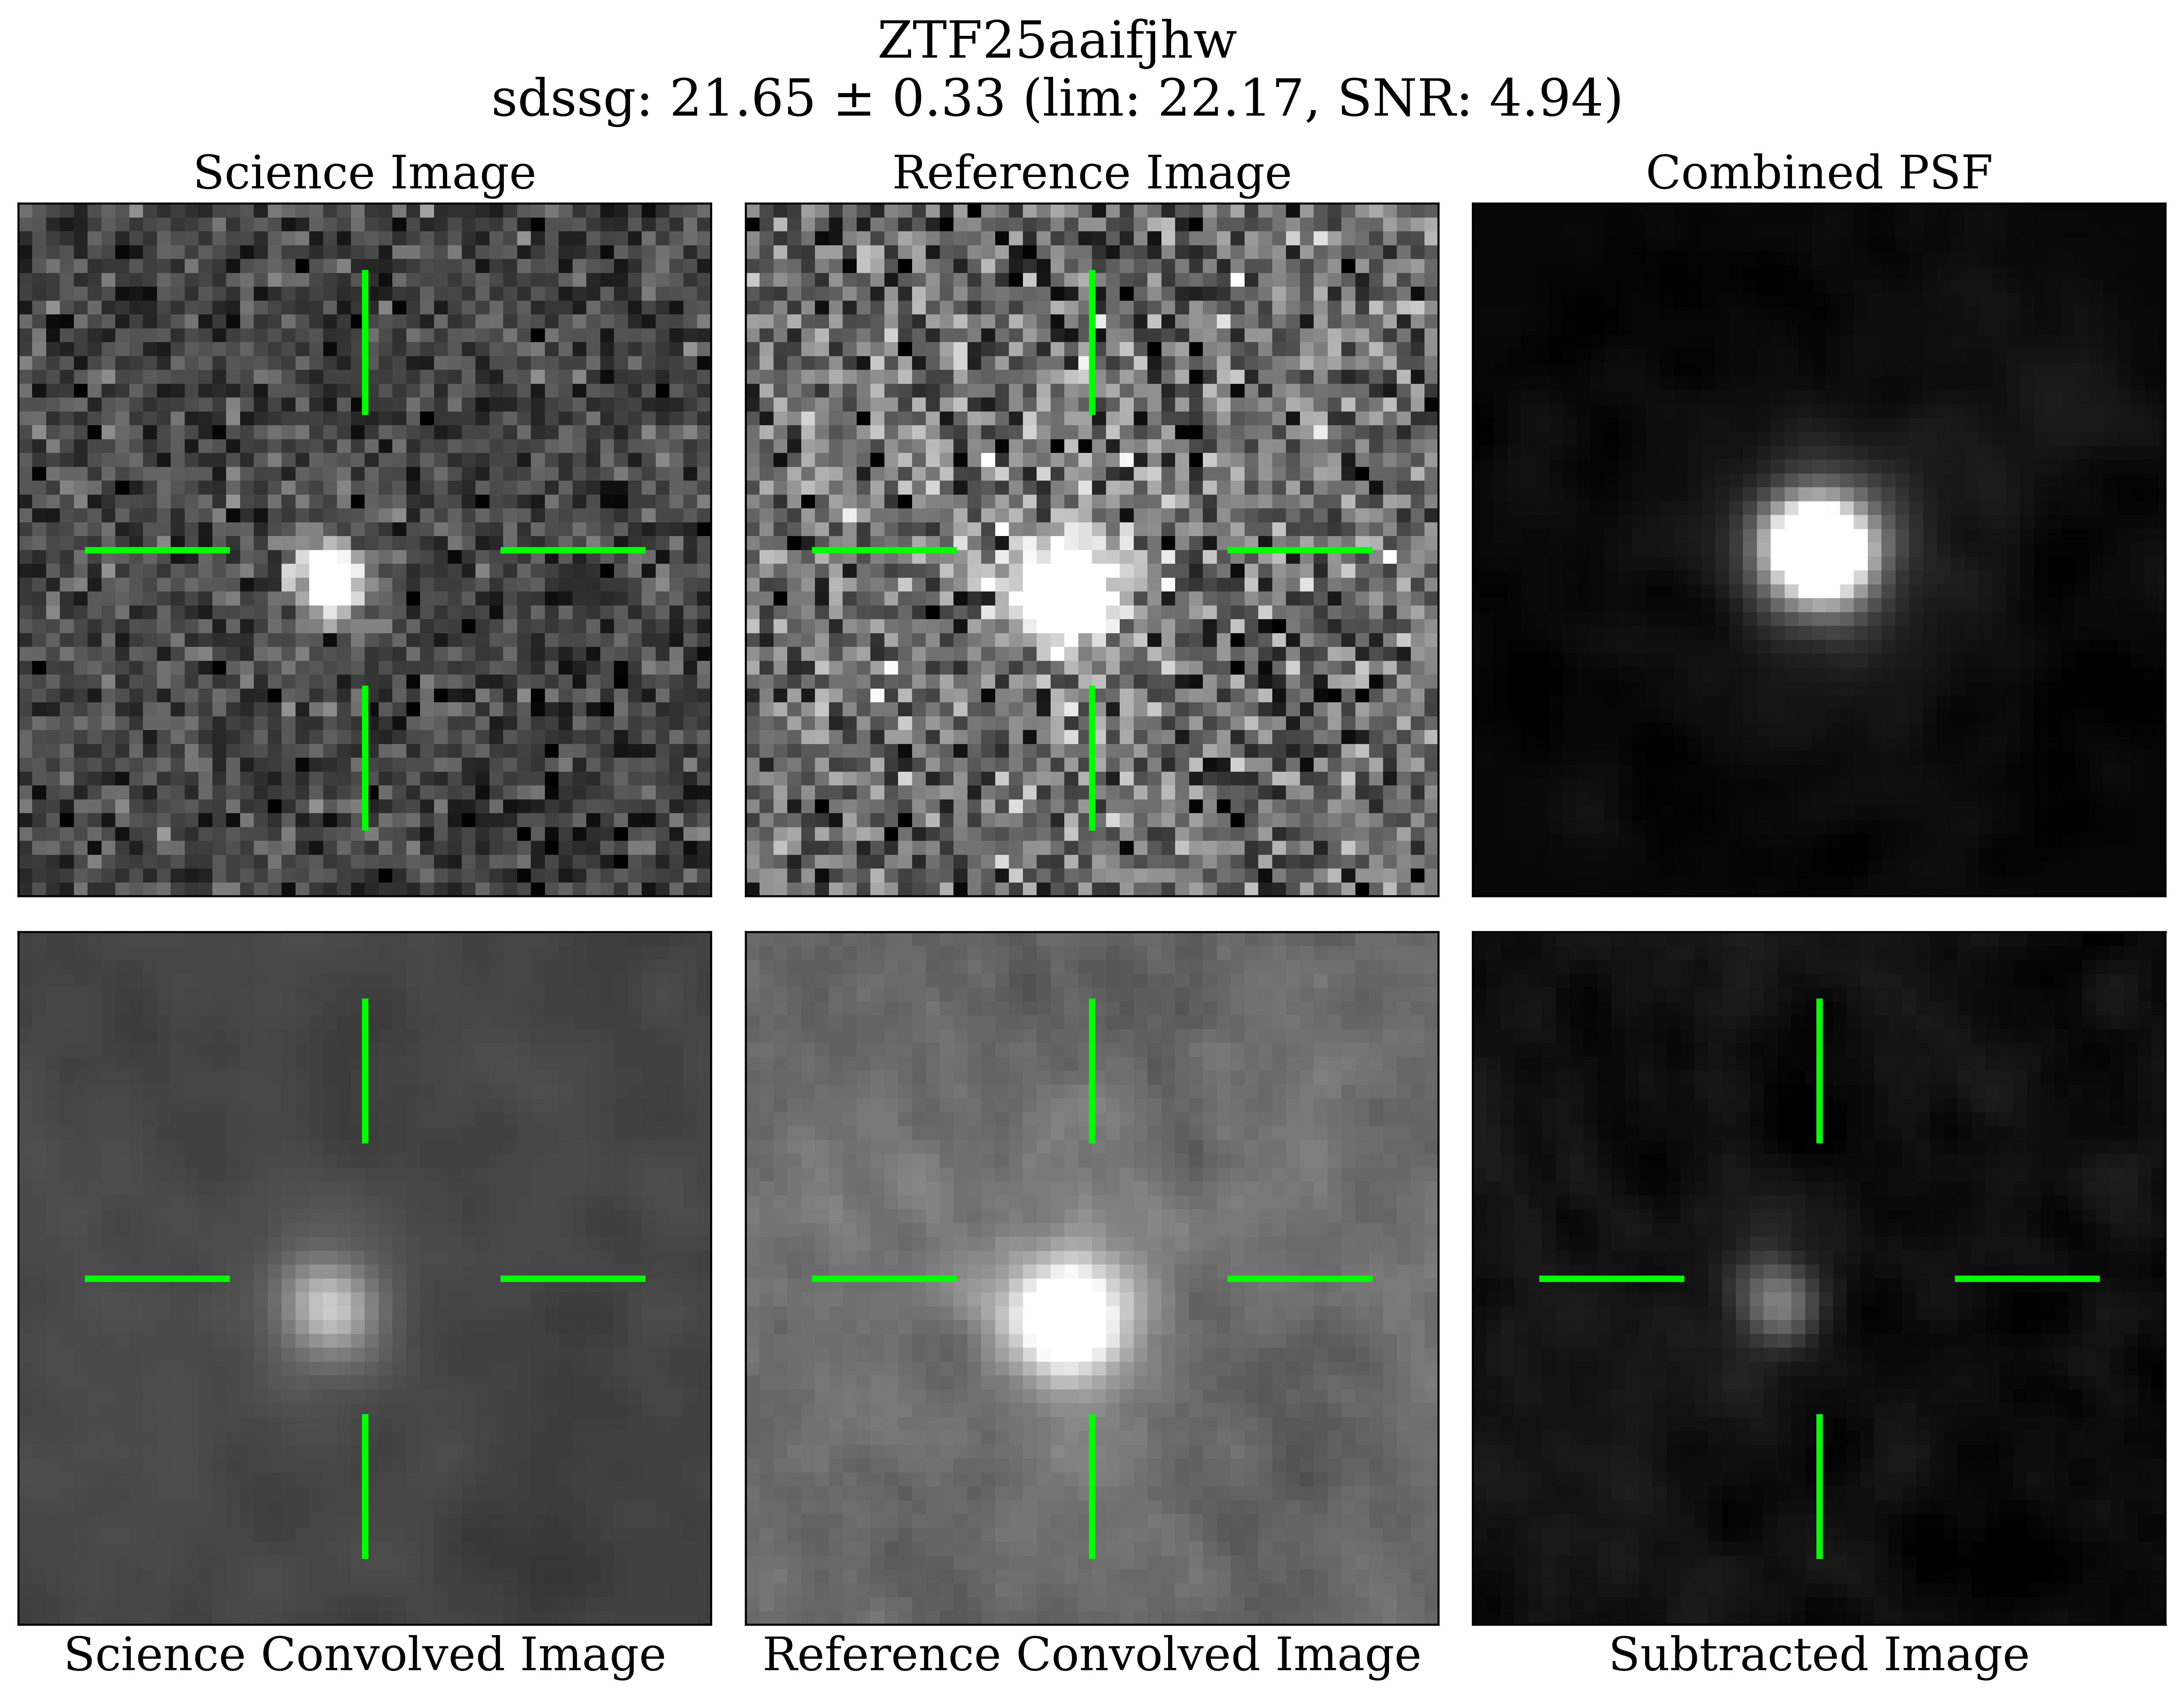

In [52]:
sci = '/mnt/data1/users/arikhind/phot_data/aligned_images/ZTF25aaifjhw_g2025-04-17_81457bkgsub.resamp.fits'
ref = '/mnt/data1/users/arikhind/phot_data/aligned_images/stack_g_ra187.784042_dec44.110058_arcsec686_skycell2258.001.resamp.fits'

sci_conv = '/mnt/data1/users/arikhind/phot_data/convolved_sci/ZTF25aaifjhw_g_2025-04-17_81457sci_convolved.fits'
ref_conv = '/mnt/data1/users/arikhind/phot_data/convolved_ref/ZTF25aaifjhw_g_2025-04-17_81457ref_convolved.fits'

comb_psf = '/mnt/data1/users/arikhind/phot_data/convolved_psf/ZTF25aaifjhw_g_2025-04-17T22comb_psf_46281.fits'

sub = '/mnt/data1/users/arikhind/phot_data/scaled_subtracted_imgs/ZTF25aaifjhw_g2025-04-17_81457bkgsub_scaled_subtraction.fits'

name = 'ZTF25aaifjhw'

filt = 'g'

snr = '4.94'

mag = '21.65'
radec = '12:31:08.17 +44:06:36.21'
ra,dec = radec.split()

lim = '22.17'

mag_err = '0.33'



plot_example_images(sci, ref, comb_psf, sci_conv, ref_conv, sub,name,filt,snr,mag,ra,dec,lim,mag_err,minmax='n')

In [10]:
all_phot_files = glob.glob("/mnt/data1/users/arikhind/phot_data/photometry/*.txt")
phot_files = [i.split('/')[-1].split('_')[0] for i in all_phot_files if "phot" in i]

In [11]:
len(phot_files)
unique_phot_files = np.unique(phot_files)

#find how many files each unqiue phot file has
phot_counts = {}
phot_data_files_sorts = {}
all_phot_files = np.array(all_phot_files)
for i in unique_phot_files:
    data = [j for j in all_phot_files if i in j]
    phot_counts[i] = len(data)
    phot_data_files_sorts[i] = data

In [12]:
phot_data_files_sorts['ZTF23aalftvv']

['/mnt/data1/users/arikhind/phot_data/photometry/ZTF23aalftvv_r2023-08-08T03_14358_photometry.txt',
 '/mnt/data1/users/arikhind/phot_data/photometry/ZTF23aalftvv_r2023-08-21_78345_photometry.txt',
 '/mnt/data1/users/arikhind/phot_data/photometry/ZTF23aalftvv_g2023-09-14T03_13740_photometry.txt',
 '/mnt/data1/users/arikhind/phot_data/photometry/ZTF23aalftvv_g2023-08-09T06_22153_photometry.txt',
 '/mnt/data1/users/arikhind/phot_data/photometry/ZTF23aalftvv_g2023-08-13T08_30360_photometry.txt',
 '/mnt/data1/users/arikhind/phot_data/photometry/ZTF23aalftvv_g2023-08-15T08_30770_photometry.txt',
 '/mnt/data1/users/arikhind/phot_data/photometry/ZTF23aalftvv_g2023-08-17T06_24289_photometry.txt',
 '/mnt/data1/users/arikhind/phot_data/photometry/ZTF23aalftvv_g2023-08-23T05_18005_photometry.txt',
 '/mnt/data1/users/arikhind/phot_data/photometry/ZTF23aalftvv_g2023-08-27T05_18602_photometry.txt',
 '/mnt/data1/users/arikhind/phot_data/photometry/ZTF23aalftvv_g2023-08-29T05_19879_photometry.txt',
 '/

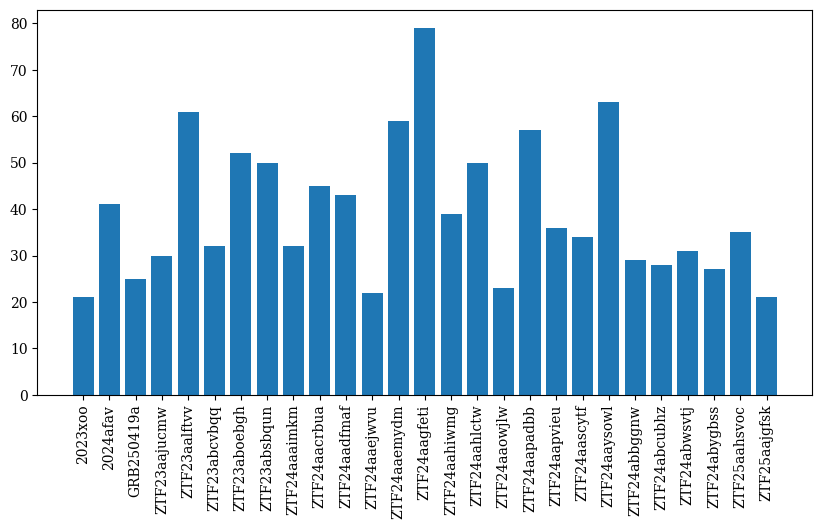

In [14]:
plt.figure(figsize=(10, 5))
new_phot_counts = {k: v for k, v in phot_counts.items() if v > 20 and v<100}
# plt.bar(phot_counts.keys(), phot_counts.values())
x = plt.bar(new_phot_counts.keys(), new_phot_counts.values())
x = plt.xticks(rotation=90)

In [3]:
def read_phot_files(file_):
    data1 = open(file_,'r')
    line1,line2 = np.asarray(data1.readlines()[:2])#.split(' ')[:-1])
    # print(line1)#,line2)
    line1 = line1.split(' ')[:-1]
    if 'Liverpool' in line2:line1.append('LT')
    else:line1.append(line2.split(' ')[-1][:-1])


    return line1

def api(method,endpoint,data=None):
    headers={"Authorization":f"token {token}"}
    response=requests.request(method.upper(),urllib.parse.urljoin("https://fritz.science", endpoint),json=data,headers=headers)

    return response

def SN_data_phot(name):
    '''Retrieves individual events, form needs to be an array or a list, puts data into a dataframe'''
    data_array = []


    # while True:
    response = api("get", f"api/sources/{name}/photometry")
    # if response.status_code==200:
        # break
    data = response.json().get("data", None)
    print(response.status_code)
    if len(data) ==0:
        df = pd.DataFrame()
    else:
        df = pd.DataFrame(data).sort_values(by=['mjd'], ascending=True)

    sedm = df.loc[df['instrument_name']=='SEDM']
    ztf = df.loc[df['instrument_name']=='ZTF']
    uvot = df.loc[df['instrument_name']=='UVOT']
    alfosc = df.loc[df['instrument_name']=='ALFOSC']

    return df,sedm,ztf,uvot,alfosc

In [ ]:
# SN2023ixf IIP       Y
# ZTF23aboebgh Ic-SL  Y
# ZTF24aaemydm IIP    Y
# ZTF23aajucmw II     Y
# ZTF24aadfmaf Ic-SL  Y
# ZTF24aaysowl Ic-SL  Y  
# ZTF23abcvbqq TDE 

In [ ]:

fold_name='/mnt/data1/users/arikhind/phot_data/photometry'
even_name='SN2023ixf'
print(os.path.exists(fold_name))

200


/tmp/ipykernel_853462/609275580.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ztf_f['mjd'] = ztf_f['mjd']-day_now
/tmp/ipykernel_853462/609275580.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sedm_f['mjd'] = sedm_f['mjd']-day_now


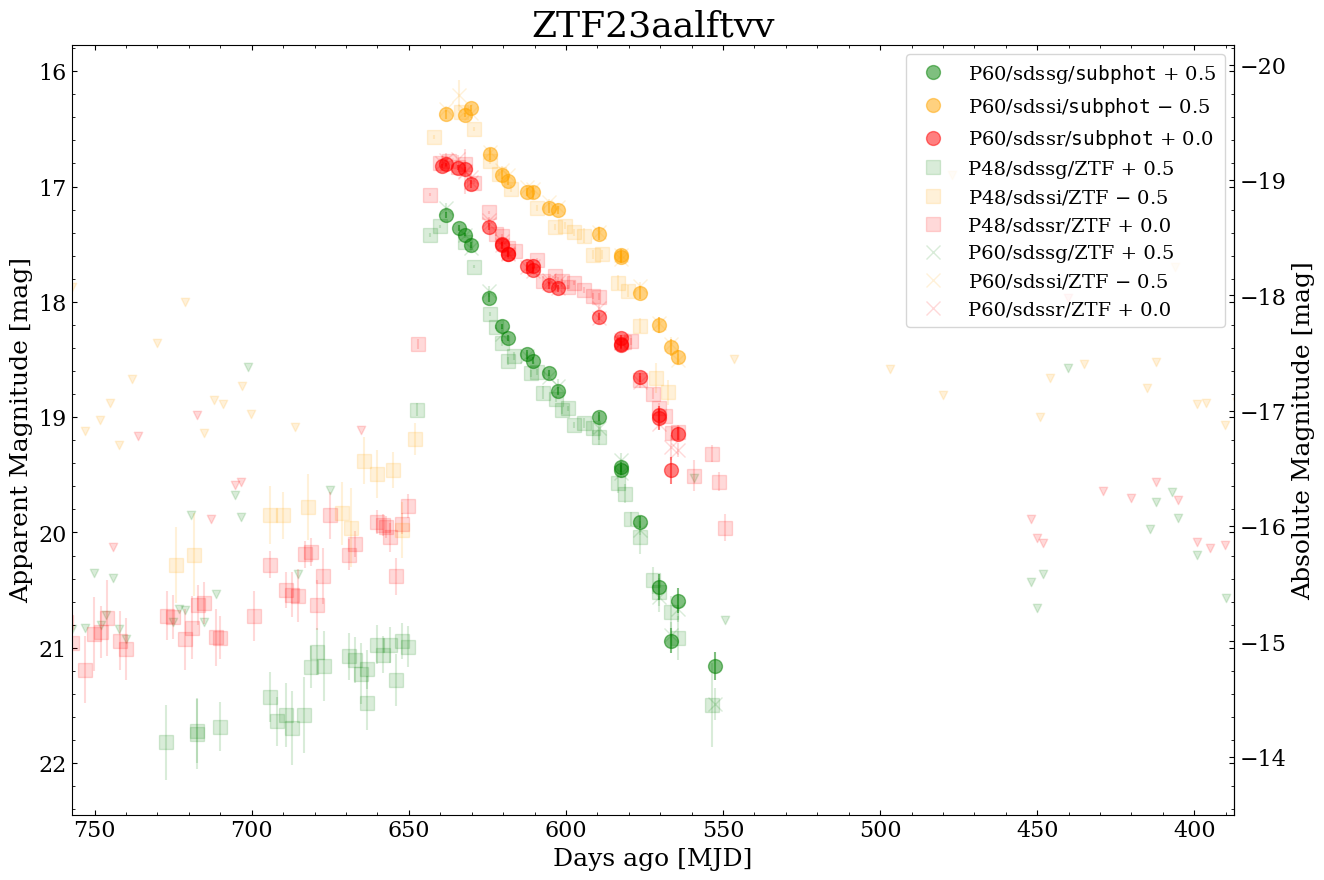

In [17]:
filt_cols = {'sdssg':'g','sdssr':'r','sdssi':'orange','sdssz':'brown','sdssu':'blue',
             'uvot::uvw1':'pink','uvot::uvm2':'lilac','uvot::u':'purple',
             'uvot::v':'purple','uvot::b':'purple','uvot::uvw2':'purple',
             }
instr_marks = {'LT':'o','ZTF':'s','SEDM_FPIPE_SDSS':'x','UVOT':'^','ALFOSC':'v'}
intr_names = {'LT':'IO:O/LT','ZTF':'P48/ZTF','SEDM_FPIPE_SDSS':'RCAM/P60','UVOT':'UVOT/Swift','ALFOSC':'ALFOSC/NOT'}
offset = {'sdssg':[0.5,'+ 0.5'],
          'sdssr':[0,'+ 0.0'],
          'sdssi':[-0.5,'$-$ 0.5'],
          'sdssz':[-1,'$-$ 1.0'],
          'sdssu':[1.0,'+ 1.0'],
          'uvot::uvw1':[1.5,'+ 1.5.0'],
          'uvot::uvw2':[1.75,'+ 1.75'],
          'uvot::uvm2':[2,'+ 2.0'],
          'uvot::u':[1,'+ 1.0'],
          'uvot::v':[0.5,'+ 0.5'],
          'uvot::b':[0.25,'+ 0.25'],
          }

def read_n_plot(name,dm=0,SEDM=False):
  day_now = Time.now().mjd
  ind = [0,1,2,3,4,-1,5,8]
  df = pd.DataFrame(columns=['name','filter','mjd','mag','mag_err','telescope','mag_lim','expt'])
  c=0
  S=10
  files = phot_data_files_sorts[name]
  for file_ in files:
      line1 = read_phot_files(file_)
      df.loc[c] = [line1[i] for i in ind]
      c+=1

  df['name'] =[name.replace('-ugriz','') for name in df['name']]
  df['mjd'] = df['mjd'].astype(float)-day_now
  df['mag'] = df['mag'].astype(float)
  df['mag_err'] = df['mag_err'].astype(float)
  df['telescope'] = df['telescope'].astype(str)
  df['filter'] = df['filter'].astype(str)
  df['mag_lim'] = df['mag_lim'].astype(float)
  df['expt'] = df['expt'].astype(float)


  fig=plt.figure(figsize=(15,10))
  unique_filts = np.unique(df['filter'])
  fritz_df,sedm,ztf,uvot,alfosc = SN_data_phot(name)
  lt_legend, p48_legend, p60_legend, uvot_legend, alfosc_legend = [],[],[],[],[]
  for filt in unique_filts:
      if not SEDM:
        df_lt_ = df.loc[(df['filter']==filt)&(df['telescope']=='LT')&(df['mag']<30)&(df['mag_err']<1)]
        df_lt_ul = df.loc[(df['mag']>30)&(df['filter']==filt)]
        p1 = plt.errorbar(abs(df_lt_['mjd']),df_lt_['mag']+offset[filt][0],yerr=df_lt_['mag_err'],fmt='o',label='IO:O/'+filt+'/LT '+offset[filt][1],
                    alpha=0.5,color=filt_cols[filt],markersize=S)
        lt_legend.append([p1[0],'IO:O/'+filt+'/LT '+offset[filt][1]])

        p2 = plt.scatter(abs(df_lt_ul['mjd']),df_lt_ul['mag_lim']+offset[filt][0],marker='v',label='IO:O/'+filt+'/LT (UL)'+offset[filt][1],
                    color=filt_cols[filt],alpha=0.75)
        # lt_legend.append([p2,'IO:O/'+filt+'/LT (UL)'+offset[filt][1]])
      else:
        df_lt_ = df.loc[(df['filter']==filt)&(df['telescope']=='SEDM-P60')&(df['mag']<30)&(df['mag_err']<1)]
        df_lt_ul = df.loc[(df['mag']>30)&(df['filter']==filt)]
        p1 = plt.errorbar(abs(df_lt_['mjd']),df_lt_['mag']+offset[filt][0],yerr=df_lt_['mag_err'],fmt='o',label='P60/'+filt+'/ZTF '+offset[filt][1],
                    alpha=0.5,color=filt_cols[filt],markersize=S)
        lt_legend.append([p1[0],'P60/'+filt+'/'+r'$\mathtt{subphot}$ '+offset[filt][1]])

        p2 = plt.scatter(abs(df_lt_ul['mjd']),df_lt_ul['mag_lim']+offset[filt][0],marker='v',label='P60/'+filt+'/ZTF (UL)'+offset[filt][1],
                    color=filt_cols[filt],alpha=0.75)
        # lt_legend.append([p2,'IO:O/'+filt+'/LT (UL)'+offset[filt][1]])


  if name != 'SN2023ixf':
    for filt in unique_filts:
        ztf_f = ztf.loc[(ztf['filter']=='ztf'+filt[-1])&(ztf['origin']=='fp')]
        if len(ztf_f)==0:ztf_f = ztf.loc[(ztf['filter']=='ztf'+filt[-1])]
        ztf_f['mjd'] = ztf_f['mjd']-day_now
        if len(ztf_f)>0:
            ztf_det = ztf_f.loc[(~np.isnan(ztf_f['mag']))&(~np.isnan(ztf_f['magerr']))]
            ztf_non = ztf_f.loc[(np.isnan(ztf_f['mag']))|(np.isnan(ztf_f['magerr']))]
            p1 = plt.errorbar(abs(ztf_det['mjd']),ztf_det['mag']+offset[filt][0],yerr=ztf_det['magerr'],fmt='s',label='P48/'+filt+'/ZTF '+offset[filt][1],
                        alpha=0.15,color=filt_cols[filt],markersize=S)
            p2 = plt.scatter(abs(ztf_non['mjd']),ztf_non['limiting_mag']+offset[filt][0],marker='v',color=filt_cols[filt],alpha=0.15)
            lt_legend.append([p1[0],'P48/'+filt+'/ZTF '+offset[filt][1]])
            # lt_legend.append([p2,'P48/'+filt+'/ZTF (UL)'+offset[filt][1]])



    for filt in unique_filts:
        sedm_f = sedm.loc[(sedm['filter']==filt)]
        sedm_f['mjd'] = sedm_f['mjd']-day_now
        # print(filt,sedm_f)

        if len(sedm_f)>0:
            sedm_det = sedm_f.loc[(~np.isnan(sedm_f['mag']))&(~np.isnan(sedm_f['magerr']))]
            sedm_non = sedm_f.loc[(np.isnan(sedm_f['mag']))|(np.isnan(sedm_f['magerr']))]
            p1 = plt.errorbar(abs(sedm_det['mjd']),sedm_det['mag']+offset[filt][0],yerr=sedm_det['magerr'],fmt='x',label='RCAM/'+filt+'/SEDM '+offset[filt][1],
                        alpha=0.15,color=filt_cols[filt],markersize=S)
            p2 = plt.scatter(abs(sedm_non['mjd']),sedm_non['limiting_mag']+offset[filt][0],marker='v',color=filt_cols[filt],alpha=0.15)
            lt_legend.append([p1[0],'P60/'+filt+'/ZTF '+offset[filt][1]])
            # lt_legend.append([p2,'P60/'+filt+'/ZTF (UL)'+offset[filt][1]])

  # for filt in unique_filts:
  #     alfosc_f =alfosc.loc[(alfosc['filter']==filt)]
  #     alfosc_f['mjd'] = alfosc_f['mjd']-day_now
  #     if len(alfosc_f)>0:

  #         alfosc_det = alfosc_f.loc[(~np.isnan(alfosc_f['mag']))&(~np.isnan(alfosc_f['magerr']))]
  #         alfosc_non = alfosc_f.loc[(np.isnan(alfosc_f['mag']))|(np.isnan(alfosc_f['magerr']))]
  #         p = plt.errorbar(abs(alfosc_det['mjd']),alfosc_det['mag']+offset[filt][0],yerr=alfosc_det['magerr'],fmt='v',label='ALFOSC/'+filt+'/NOT '+offset[filt][1],
  #                     alpha=0.15,color=filt_cols[filt])
  #         alfosc_legend.append([p,'ALFOSC/'+filt+'/NOT '+offset[filt][1]])
  #         plt.scatter(abs(alfosc_non['mjd']),alfosc_non['limiting_mag']+offset[filt][0],marker='v',color=filt_cols[filt],alpha=0.5)
    
  # for filt in ['uvot::u','uvot::v','uvot::b',]:
  #     uvot_f = uvot.loc[(uvot['filter']==filt)]
  #     uvot_f['mjd'] = uvot_f['mjd']-day_now


  #     if len(uvot_f)>0:
  #         uvot_det = uvot_f.loc[(~np.isnan(uvot_f['mag']))&(~np.isnan(uvot_f['magerr']))]
  #         uvot_non = uvot_f.loc[(np.isnan(uvot_f['mag']))|(np.isnan(uvot_f['magerr']))]
  #         p = plt.errorbar(abs(uvot_det['mjd']),uvot_det['mag']+offset[filt][0],yerr=uvot_det['magerr'],fmt='^',label='UVOT/'+filt+'/UVOT '+offset[filt][1],
  #                     alpha=0.15,color=filt_cols[filt])
  #         uvot_legend.append([p,'UVOT/'+filt+'/UVOT '+offset[filt][1]])
  #         plt.scatter(abs(uvot_non['mjd']),uvot_non['limiting_mag']+offset[filt][0],marker='v',color=filt_cols[filt],alpha=0.5)

  # print(lt_legend)
  # lt_legend, p48_legend, p60_legend, uvot_legend, alfosc_legend = np.array(lt_legend),np.array(p48_legend),np.array(p60_legend),np.array(uvot_legend),np.array(alfosc_legend)
  # legend = np.concatenate((lt_legend,p48_legend,p60_legend,uvot_legend,alfosc_legend),axis=0)
  # print(legend)
  lt_legend = np.array(lt_legend)
  plt.gca().invert_yaxis()
  plt.legend(lt_legend[:,0],lt_legend[:,1],
      loc='upper right',ncols=1,fontsize=14,)
  plt.gca().invert_xaxis()
  plt.ylabel('Apparent Magnitude [mag]',fontsize=18)
  plt.xlabel(f'Days ago [MJD]',fontsize=18)
  plt.title(name,fontsize=26)
  try:
    peak_mag = np.nanmin(ztf['mag'])
    peak_time = abs(ztf['mjd'][ztf['mag'].idxmin()]-day_now)
  except:
    peak_mag = np.nanmin(df['mag'])
    peak_time = abs(df['mjd'][df['mag'].idxmin()])
  if name == 'SN2023ixf':
     plt.xlim(peak_time+30,peak_time-650)
  else:
    plt.xlim(peak_time+120,peak_time-250)
  plt.tick_params(axis="both", direction="in", 
                  which="both", right=True, top=True,
                  labelsize=16)
  
  second_yaxis = plt.gca().secondary_yaxis('right',functions=(lambda x: x-dm,lambda x: x+dm))
  second_yaxis.set_ylabel('Absolute Magnitude [mag]',fontsize=18)
  second_yaxis.tick_params(axis="both", direction="in",
                  which="both", right=True, top=True,
                  labelsize=16)

  plt.minorticks_on()
  # plt.ylim(None,18)
  fig.savefig(f'ThesisFigs/{name}_subphot_LC.pdf',bbox_inches='tight',format='pdf')

  # plt.xlim(300,0)

# read_n_plot('ZTF23aboebgh',39.337)
# read_n_plot('ZTF24aaemydm',33.755)

# read_n_plot('ZTF24aaysowl',38.79)
# SN2023ixf IIP       Y
# read_n_plot('SN2023ixf',29.194)
# read_n_plot('ZTF23abcvbqq',38.79)

# ZTF24aadfmaf Ic-SL  Y
# read_n_plot('ZTF24aadfmaf',37.479)
# read_n_plot('ZTF23aajucmw',38.431)
read_n_plot('ZTF23aalftvv',35.945,True)


200


/tmp/ipykernel_853462/609275580.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ztf_f['mjd'] = ztf_f['mjd']-day_now
/tmp/ipykernel_853462/609275580.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sedm_f['mjd'] = sedm_f['mjd']-day_now


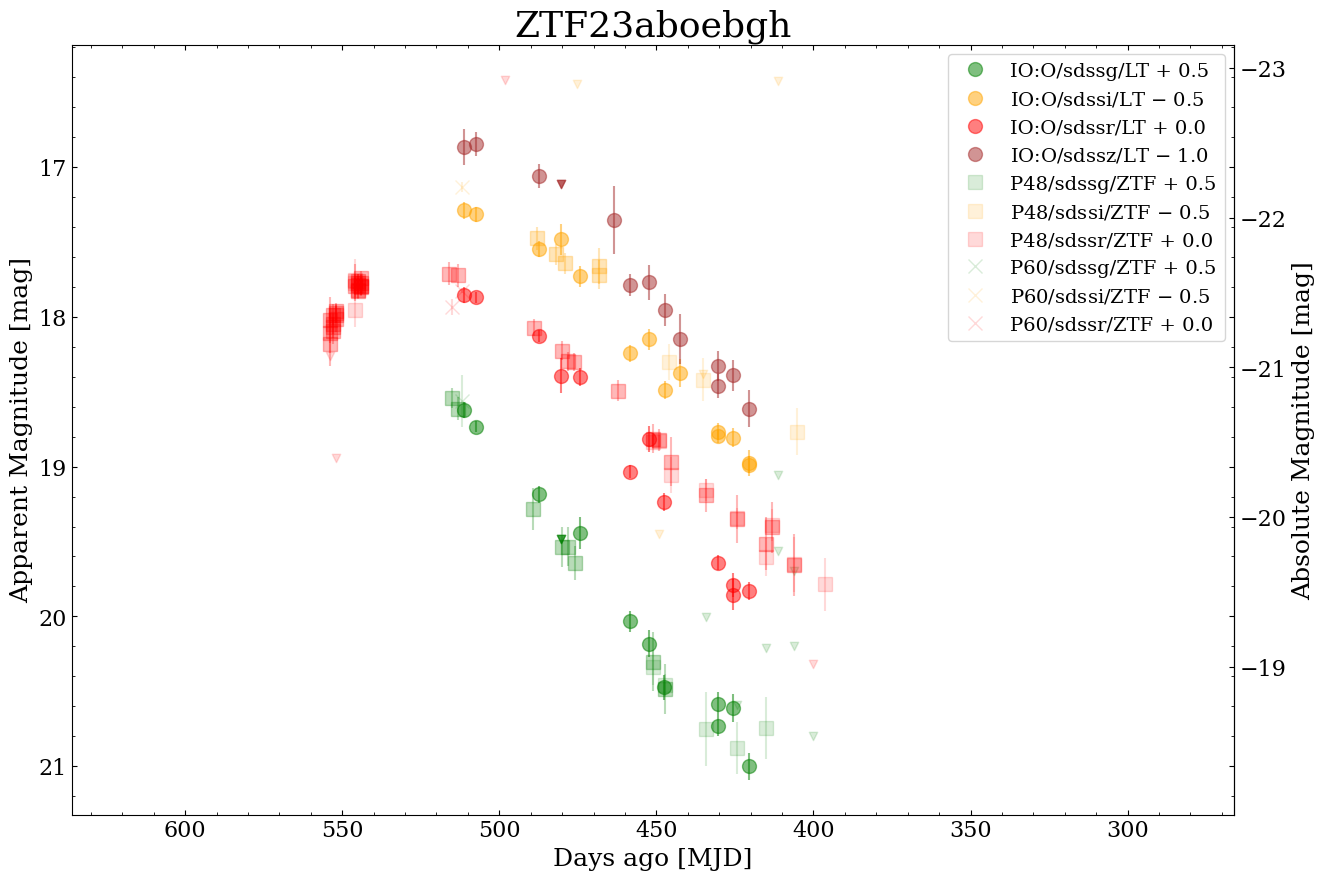

In [18]:
read_n_plot('ZTF23aboebgh',39.337)

200


/tmp/ipykernel_853462/609275580.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ztf_f['mjd'] = ztf_f['mjd']-day_now
/tmp/ipykernel_853462/609275580.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sedm_f['mjd'] = sedm_f['mjd']-day_now


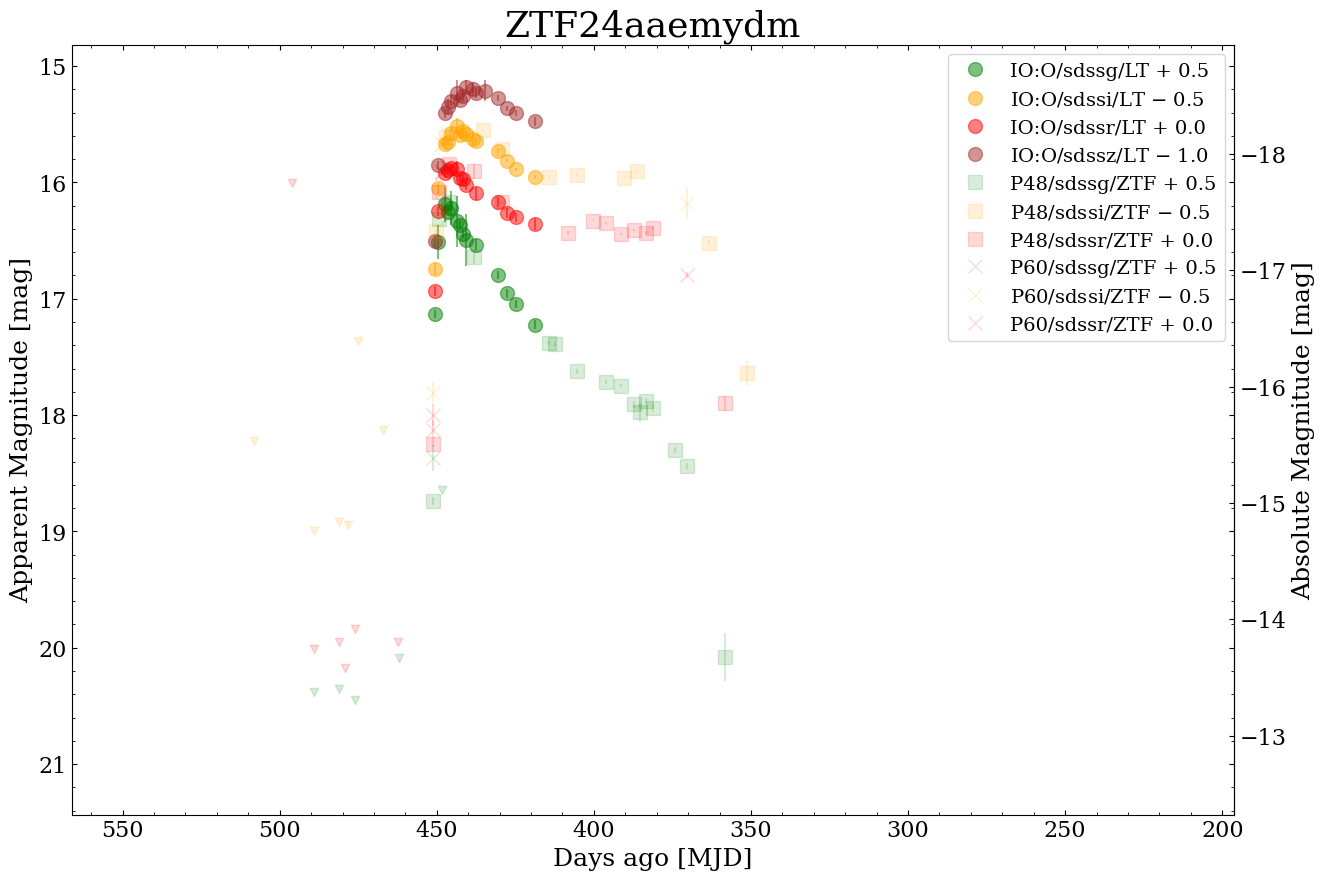

In [20]:
# ZTF24aaemydm IIP    Y
read_n_plot('ZTF24aaemydm',33.755)


200


/tmp/ipykernel_853462/609275580.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ztf_f['mjd'] = ztf_f['mjd']-day_now
/tmp/ipykernel_853462/609275580.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sedm_f['mjd'] = sedm_f['mjd']-day_now


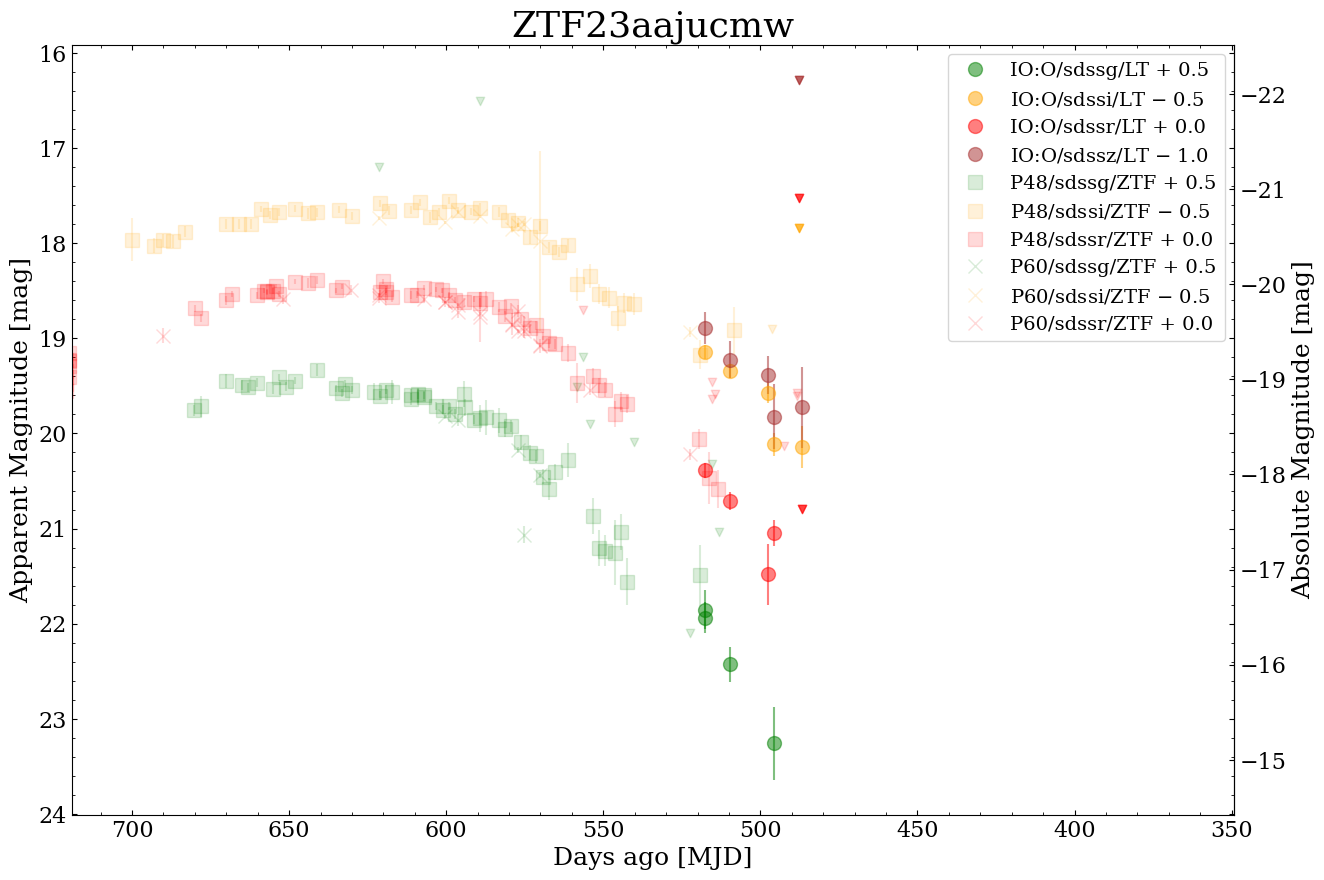

In [21]:
# ZTF23aajucmw II     Y
read_n_plot('ZTF23aajucmw',38.431)


200


/tmp/ipykernel_853462/609275580.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ztf_f['mjd'] = ztf_f['mjd']-day_now
/tmp/ipykernel_853462/609275580.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sedm_f['mjd'] = sedm_f['mjd']-day_now


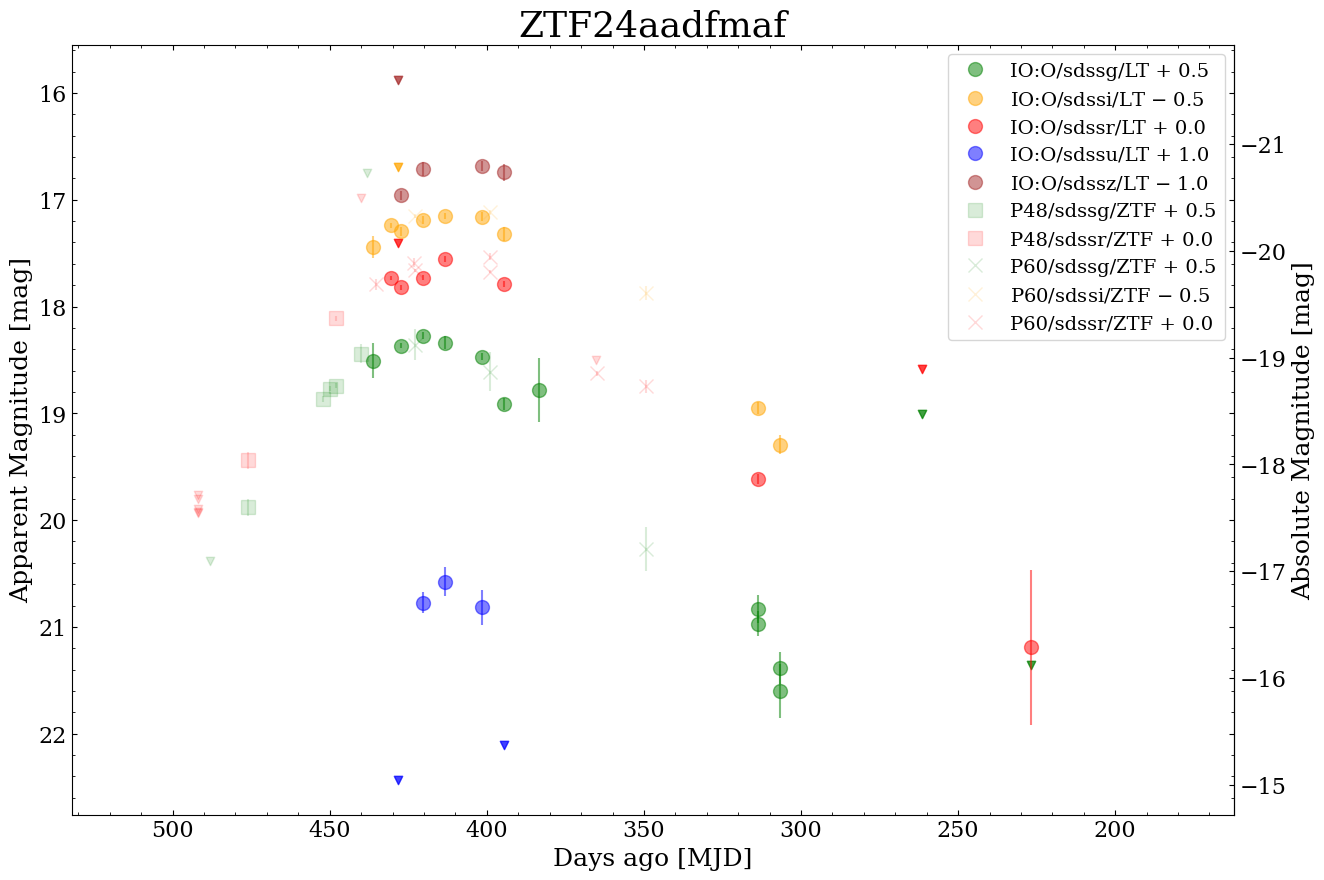

In [22]:
# ZTF24aadfmaf Ic-SL  Y
read_n_plot('ZTF24aadfmaf',37.479)
# read_n_plot('ZTF23aajucmw',38.431)


200


/tmp/ipykernel_853462/609275580.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ztf_f['mjd'] = ztf_f['mjd']-day_now
/tmp/ipykernel_853462/609275580.py:87: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sedm_f['mjd'] = sedm_f['mjd']-day_now


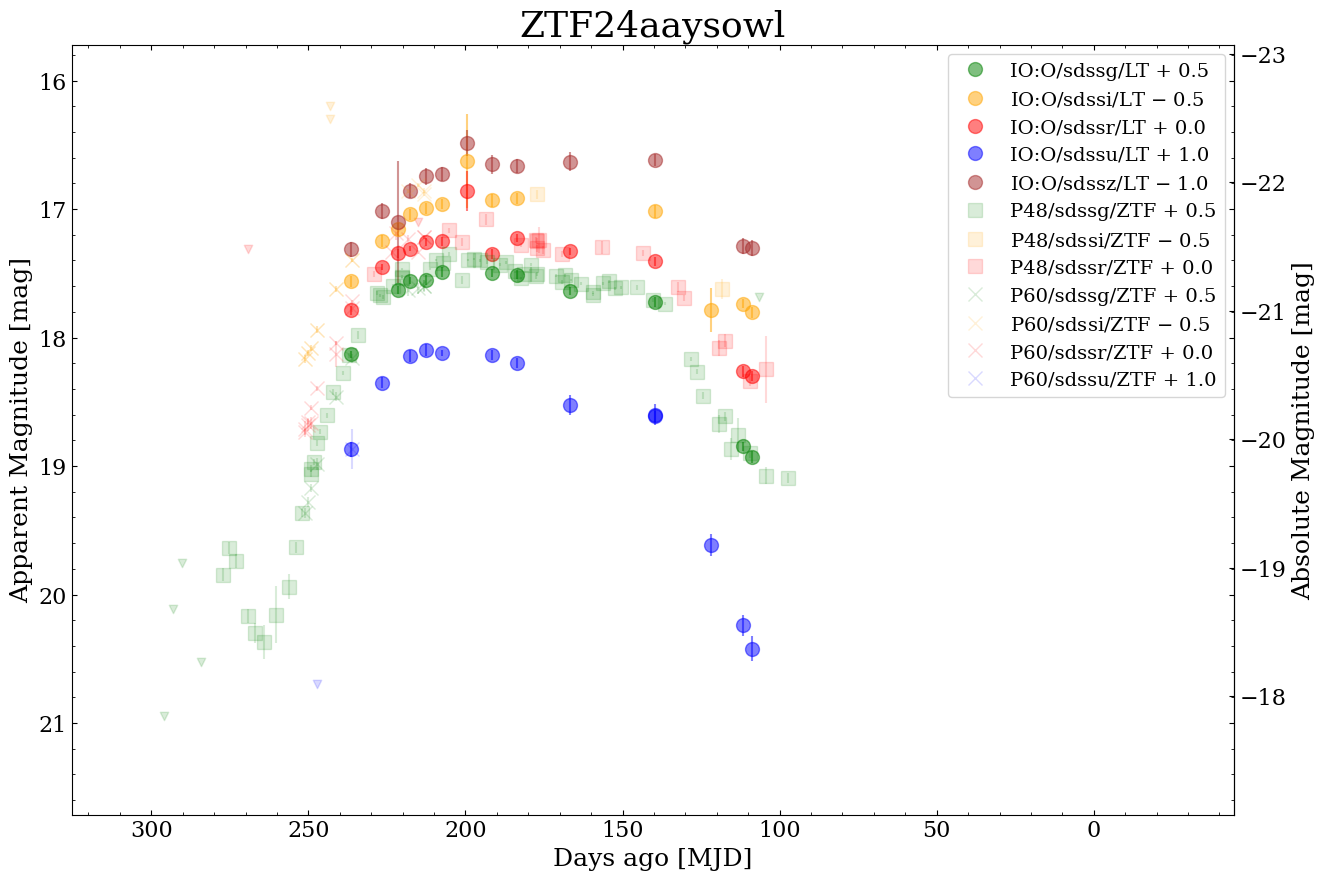

In [23]:
# ZTF24aaysowl Ic-SL  Y  
read_n_plot('ZTF24aaysowl',38.790)


200
[[<matplotlib.lines.Line2D object at 0x7fd32d892990>, 'IO:O/sdssg/LT + 0.5'], [<matplotlib.collections.PathCollection object at 0x7fd32ae0ed20>, 'IO:O/sdssg/LT (UL)+ 0.5'], [<matplotlib.lines.Line2D object at 0x7fd32d6b7da0>, 'IO:O/sdssi/LT $-$ 0.5'], [<matplotlib.collections.PathCollection object at 0x7fd32afb1a30>, 'IO:O/sdssi/LT (UL)$-$ 0.5'], [<matplotlib.lines.Line2D object at 0x7fd32a6625d0>, 'IO:O/sdssr/LT + 0.0'], [<matplotlib.collections.PathCollection object at 0x7fd32aa853d0>, 'IO:O/sdssr/LT (UL)+ 0.0'], [<matplotlib.lines.Line2D object at 0x7fd32a661250>, 'IO:O/sdssz/LT $-$ 1.0'], [<matplotlib.collections.PathCollection object at 0x7fd32dff5dc0>, 'IO:O/sdssz/LT (UL)$-$ 1.0'], [<matplotlib.lines.Line2D object at 0x7fd32af558e0>, 'P48/sdssg/ZTF + 0.5'], [<matplotlib.collections.PathCollection object at 0x7fd32af55cd0>, 'P48/sdssg/ZTF (UL)+ 0.5'], [<matplotlib.lines.Line2D object at 0x7fd32af552b0>, 'P48/sdssi/ZTF $-$ 0.5'], [<matplotlib.collections.PathCollection object a

/tmp/ipykernel_4059368/1733573417.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ztf_f['mjd'] = ztf_f['mjd']-day_now
/tmp/ipykernel_4059368/1733573417.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sedm_f['mjd'] = sedm_f['mjd']-day_now


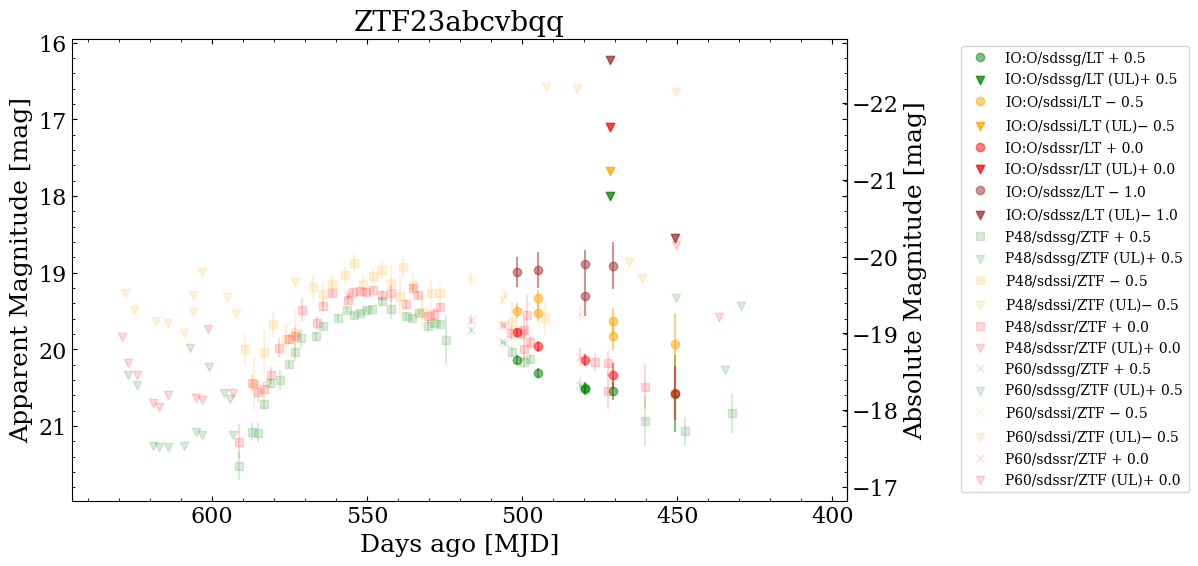

In [120]:
# ZTF23abcvbqq TDE 
read_n_plot('ZTF23abcvbqq',38.79)

200


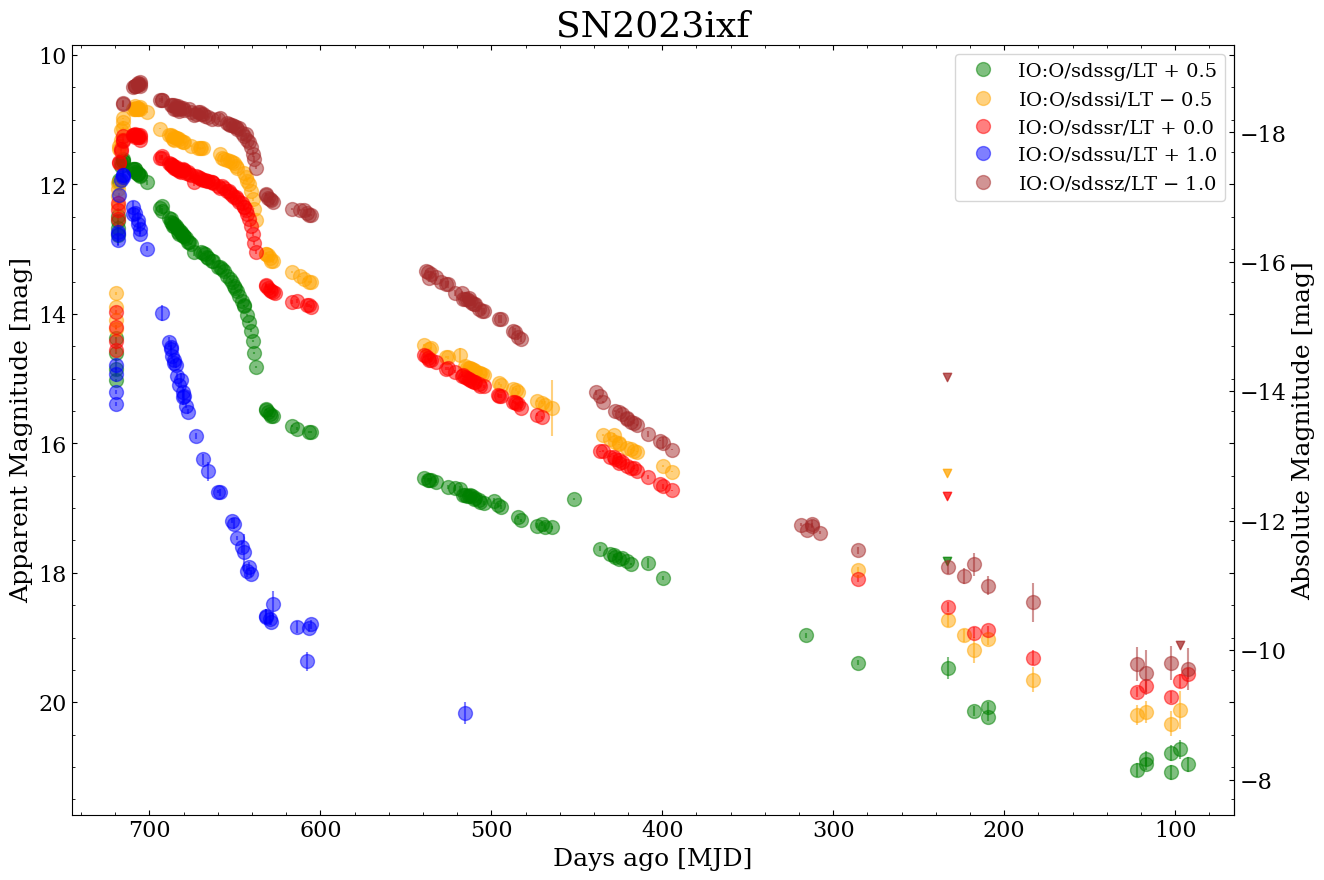

In [24]:
# SN2023ixf IIP       Y
read_n_plot('SN2023ixf',29.194)



In [ ]:
#plot on data with telescope==LT as circles
filt_cols = {'sdssg':'g','sdssr':'r','sdssi':'orange','sdssz':'brown','sdssu':'blue'}
fig=plt.figure(figsize=(10,6))
unique_filts = np.unique(df['filter'])
for filt in unique_filts:
    # if filt=='sdssu':continue
    # print(filt)
    df_lt_ = df.loc[(df['filter']==filt)&(df['telescope']=='LT')&(df['mag']<30)&(df['mag_err']<1)]
    plt.errorbar(abs(df_lt_['mjd']-day_now),df_lt_['mag'],yerr=df_lt_['mag_err'],fmt='o',label='IOO/LT '+filt,alpha=0.5,color=filt_cols[filt])
    df_lt_ul = df.loc[(df['mag']>30)&(df['filter']==filt)]
    # print(df_lt_ul)
    plt.scatter(abs(df_lt_ul['mjd']-day_now),df_lt_ul['mag_lim'],marker='v',color=filt_cols[filt],alpha=0.5)

# for filt in unique_filts:
    # df_slt_= df.loc[(df['filter']==filt)&(df['telescope']=='SLT')&(df['mag']<30)]
    # plt.errorbar(df_slt_['mjd'],df_slt_['mag'],yerr=df_slt_['mag_err'],fmt='x',label='SLT '+filt,alpha=0.5,color=filt_cols[filt])


    # df_gtc_osiris = df.loc[(df['filter']==filt)&(df['telescope']=='GTC-OSIRIS')&(df['mag']<30)]
    # plt.errorbar(df_gtc_osiris['mjd'],df_gtc_osiris['mag'],yerr=df_gtc_osiris['mag_err'],fmt='s',label='GTC-OSIRIS '+filt,alpha=0.5,color=filt_cols[filt])

plt.gca().invert_yaxis()
plt.legend(loc='upper right',bbox_to_anchor=(1.3,1),ncols=1)
# plt.xlim(60550,)
plt.gca().invert_xaxis()
plt.ylabel('Mag')
# day_now=0
plt.xlabel('Days ago'+' ('+str(day_now)+')')
# df.to_csv('2023ixf_LT_K_phot.csv',index=False)
# plt.xlim(60221.1,60221.16)
# df['mjd'].loc[(df['mjd']<=60221.16)&(df['mjd']>=60221.1)]
# plt.axvline(60370)

In [ ]:
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context


all_sn_data = SN_data_phot(even_name)
print(np.unique(all_sn_data['instrument_name']))

# ioo = all_sn_data.loc[all_sn_data['origin']=='LT_IOO_PIPE']